Um grupo de investidores está interessado em investir na produção de animes e precisam conhecer um pouco mais sobre esse mercado.
Você foi contratado para extrair dados sobre animes e apresentar a resposta para as 10 perguntas de negócio a seguir:

1. Qual a média de score dos animes?

2. Qual o anime com maior número de votos?

3. Quais os tipos de animes?

4. Qual a média de score por tipo de anime?

5. Quais são as fontes dos animes?

6. Quantos animes estão disponíveis em português?

7. Quantos animes têm co-produtores (Co-Producer)?

8. Há animes sem produtores?

9. Quantos vezes cada produtor participou da produção de um anime?

10. Considerando o produtor que mais participou da produção de animes, qual a média de score, popularidade e membros?

Seu trabalho é fazer isso acontecer

In [1]:
# Imports
import re
import bs4
import time
import json
import requests
from bs4 import BeautifulSoup as bs

In [2]:
# Fonte de dados: (alvo do web scraping) https://myanimelist.net/topanime.php

### Funções para extração de dados web scraping


In [3]:
# Função para obter tudo que estiver nas tags td e div e com seletor CSS spaceit_pad
# Assim extraímos informações gerais da página
def getInfoGeral(soup):
    information = soup.select("td div .spaceit_pad")
    side_info_par = []
    for info in information:
        side_info_par.append(info.text.split())
    return side_info_par

In [4]:
# Função para obter o número de pessoas que adicionaram o anime aos favoritos
def getFavorite(information):
    for info in information:
        if info[0] == "Favorites:":
            data = info[1].split(",")
            return int("".join(data))
    return None

In [5]:
# Função para obter o número do episódio
def episodeNumberParser(information):
    for info in information:
        if (info[0] == "Episodes:"):
            if info[1] != "Unknown":
                return int(info[1])
            return None
    return None

In [6]:
# Função para obter o tipo de anime TV
def typeParser(information):
    for info in information:
        if (info[0] == "Type:"):
            return info[1]
    return None

In [7]:
# Função para obter o dia em que o anime estreou
def dayPremiered(information):
    for info in information:
        if (info[0] == "Premiered:"):
            premired_day = ""
            return " ".join(info[1:])
    return None

In [8]:
# Função para obter a fonte de onde do anime
def getSource(information):
    for info in information:
        if info[0] == "Source:":
            return " ".join(info[1:])
    return None

In [9]:
# Função para retornar uma lista de gêneros do anime
def getGenres(information):
    for info in information:
        if info[0] == "Genres:":
            genres = "".join(info[1:])
            return genres.split(",")
    return None

In [10]:
# Função que retorna uma lista de estúdios que estão patrocinando este anime
def getStudios(information):
    for info in information:
        if info[0] == "Studios:":
            return " ".join(info[1:])
    return None

In [11]:
# Função que retorna uma lista de empresas que realmente possuem a licença deste anime
def getLicense(information):
    for info in information:
        if info[0] == "Licensors:":
            if info[1] == "None":
                return None
            license = "".join(info[1:])
            return license.split(",")
    return None

In [12]:
# Função que obtém a classificação do filme
def getRating(information):
    for info in information:
        if info[0] == "Rating:":
            return "".join(info[1:4])
    return None

#### Como encontrar os producers:

`finding_producers = soup2.find_all(["div","a"], class_=["spaceit_pad"])`

Primeiro encontre os dados usando find_all dos produtores mencionado acima.
Em seguida, enumere os dados encontrados.

`for index, j in enumerate(div_and_a):
    if finding_producers[index].text.split("\n")[1] == "Producers:":
        print(finding_producers[index])`

Se o primeiro índice == "Producers:"  então você obtém o índice onde encontrou os "Produtores".

E então usamos o índice conforme o código abaixo.

In [13]:
# Função para obter o nome de empresas que estão financiando o anime (Producers)
def producers_names(soup):
    div_and_a = soup.find_all(["div","a"], class_=["spaceit_pad"])
    for index, j in enumerate(div_and_a):
        if div_and_a[index].text.split("\n")[1] == "Producers:":
            res = re.sub(" *", "", div_and_a[index].text)
            new_res = res.split("\n")
            for i,j in enumerate(new_res):
                if j == "Producers:":
                    return new_res[i+1].split(",")
                    break
    return None

In [14]:
# Função para obter informações de ranking -> seletor css + tag html
def getRanking(soup):
    ranking = soup.select_one(".ranked strong").text
    data = ranking.split("#")[1]
    return int(data)

In [15]:
# Função para obter o score do Anime -> seletor css apenas
def getScore(soup):
    data = float(soup.select_one(".score-label").text)
    return data

In [16]:
# Função para obter informação de popularidade -> seletor css + tag html
def getPopularity(soup):
    popularity = soup.select_one(".popularity strong").text
    data = popularity.split("#")[1]
    return int(data)

In [17]:
# Função para obter informação sobre os membros -> seletor css + tag html
def getMembers(soup):
    members = soup.select_one(".members strong").text
    data = members.split(",")
    return int("".join(data))

In [18]:
# Função para obter o número de pessoas que votaram no anime -> seletor css + tag html
def votersCount(soup):
    count = soup.select(".js-statistics-info span")
    data = []
    for i in count:
        data.append(i.text)
    if len(data) > 3:
        return int(data[2])
    return None

In [19]:
# Função para obter a voz do ator que faz a narração -> seletor css + tag html
def voiceActorsName(soup):
    actorNames = []
    names = soup.select(".js-anime-character-va-lang .spaceit_pad a")
    for name in names:
        data = "".join(name.text.split())
        actorNames.append(data)
    return actorNames

In [20]:
# Função para obter o idioma do ator que faz a narração
def voiceActorsLanguage(soup):
    languages = []
    langNames = soup.select(".js-anime-character-language")
    for language in langNames:
        lang = "".join(language.text.split())
        languages.append(lang)
    return languages

In [21]:
# Função que usa o voiceActorName e voiceActorsLanguage para criar um dataframe
# que irá anexar todas as informações relacionadas às vozes dos atores.
# Usando essas informações, dividiremos os voiceActors com base em seus idiomas.
def voiceActorNameandLanguage(soup):
    names = voiceActorsName(soup)
    languages = voiceActorsLanguage(soup)
    namesAndLang = []
    for i in range(len(names)):
        namesAndLang.append([names[i], languages[i]])
    return namesAndLang

In [22]:
# Função que retorna a ocupação de cada funcionário
def staffOccupation(soup):
    data = []
    for i in soup.select('td .js-scrollfix-bottom-rel .spaceit_pad small'):
        data.append("".join(i.text.split()))
    return data

In [23]:
# Função que retorna o nome dos funcionários
def staffName(soup):
    data = []
    for i in soup.select('td .js-scrollfix-bottom-rel a'):
        data.append("".join(i.text.split()))
    uncleanData = []
    for index, info in enumerate(data):
        if info == "Addstaff":
            uncleanData.append(data[index+1:])
            break
    cleanData = []
    for i in uncleanData:
        for j in i:
            if len(j) > 1:
                cleanData.append(j)
    return cleanData

In [24]:
# Função que concatena nome e ocupação dos funcionários
def staffNameandOccupation(soup):
    name = staffName(soup)
    occupation = staffOccupation(soup)
    nameAndOccupation = []
    for i in range(len(name)):
        nameAndOccupation.append([name[i], occupation[i]])
    return nameAndOccupation

In [25]:
# Função que retorna o nome do Anime
def animeName(soup):
    name = soup.select_one(".title-name").text
    if len(name) > 1:
        return name
    return None

In [26]:
%%time
for limit in range(0, 451, 50):

    # Lista para os links
    links = []

    # URL
    url = f"https://myanimelist.net/topanime.php?limit={limit}"
    print(url)

    # Request
    rq = requests.get(url)
    print(rq.status_code)

    # Parse do html
    soup = bs(rq.text, "html.parser")
    # print(soup)

    # Selecionando a class (css) .hoverinfo_trigger contido na tag a
    listsofA = soup.select("a.hoverinfo_trigger")
    # print(listsofA, type(listsofA))

    # Loop para extrair o atributo href da tag a
    for a in listsofA:
        links.append(a.get("href"))
        # print(a)
        # print(a.get('href'))

    # Abre o arquivo salvo
    with(open(f"animeLinks{limit}.txt", 'w', encoding='utf-8')) as file:
      # Loop para salvar em disco
      for index, link in enumerate(links):
        if index % 2 == 0:  # Verifica se o índice é par
            file.write(f'{link}\n')
            # print(link)

    # Sleep
    time.sleep(10)

In [27]:
%%time
for limit in range(0, 451, 50):

    # Lista
    animeInfo = []

    # Leitura dos arquivos txt com os links
    with open(f"animeLinks{limit}.txt", "r") as file:
        links = file.readlines()

    print(f"Fazendo Web Scraping. {limit}")

    # Request para cada link
    for link in links:

        rq = requests.get(link)

        rq2 = requests.get(link[:-2] + "/characters")

        soup = bs(rq.text, "html.parser")
        soup2 = bs(rq2.text, "html.parser")

        # Obtém info geral da página
        information = getInfoGeral(soup)

        # Extrai os dados e salva na lista no formato de dicionário
        animeInfo.append(dict(
            name                      = animeName(soup),
            producers                 = producers_names(soup),
            ranking                   = getRanking(soup),
            votersCount               = votersCount(soup),
            score                     = getScore(soup),
            popularity                = getPopularity(soup),
            members                   = getMembers(soup),
            favorite                  = getFavorite(information),
            episodes                  = episodeNumberParser(information),
            animeType                 = typeParser(information),
            premiredDate              = dayPremiered(information),
            animeSource               = getSource(information),
            genres                    = getGenres(information),
            studios                   = getStudios(information),
            licenses                  = getLicense(information),
            rating                    = getRating(information),
            voiceActorNameandLanguage = voiceActorNameandLanguage(soup2),
            staffNameandOccupation    = staffNameandOccupation(soup2)))

        # Sleep
        time.sleep(10)

    # Salvando os resultados em um txt
    with open(f"animeInfo{limit}.txt", 'w') as fout:
        json.dump(animeInfo, fout)

    # Sleep
    time.sleep(10)

In [28]:
%%time
for limit in range(0, 451, 50):

    animeInfoName = []

    # Abre os arquivos de links para leitura
    with open(f"animeLinks{limit}.txt", "r") as file:
        links = file.readlines()

    print(f"Extraindo os nomes dos animes. {limit}")

    # Loop pelos links para extrair o nome dos animes
    for link in links:
        rq = requests.get(link)
        soup = bs(rq.text, "html.parser")
        animeInfoName.append(dict(name = animeName(soup)))
        time.sleep(5)

    # Salvando os resultados em um txt no formato json
    with open(f"animeInfoNames{limit}.txt", 'w') as fout:
        json.dump(animeInfoName, fout)

    time.sleep(2)

### Web Scraping realizado em um site de animes para aprendizado.

O site foi escolhido devido a existencia da permissão para web scraping no mesmo. O projeto visa demonstrar habilidades e possibilidades de extração de dados da web para uma análise desde que seja permitido!

### Combinando os dados e extraindo com pandas

In [29]:
# Imports
import json
import pandas as pd

In [30]:
animeData = []


In [31]:
# Loop para carregar os arquivos do disco na lista
for i in range(0, 451, 50):
    with open(f"animeInfo{i}.txt") as file:
        animeInfo = json.load(file)

        for j in range(50):
            animeData.append(animeInfo[j])
print(animeInfo)

[{'name': 'Kuroko no Basket', 'producers': ['BandaiVisual', 'Lantis', 'NihonAdSystems', 'MainichiBroadcastingSystem', 'Banpresto', 'Shueisha', 'BS11'], 'ranking': 451, 'votersCount': 570079, 'score': 8.09, 'popularity': 106, 'members': 992838, 'favorite': 18811, 'episodes': 25, 'animeType': 'TV', 'premiredDate': 'Spring 2012', 'animeSource': 'Manga', 'genres': ['ComedyComedy', 'SportsSports'], 'studios': 'Production I.G', 'licenses': None, 'rating': 'PG-13-Teens', 'voiceActorNameandLanguage': [['Ono,Yuuki', 'Japanese'], ['Pascal,Benjamin', 'French'], ['Robinson,Zeno', 'English'], ['Ono,Kensho', 'Japanese'], ['Solis,Adrien', 'French'], ['Dao,Khoi', 'English'], ['Miki,Shinichiro', 'Japanese'], ['Silverstein,Keith', 'English'], ['Saitou,Chiwa', 'Japanese'], ['Nonnenmacher,Marie', 'French'], ['Trott,Abby', 'English'], ['Kamiya,Hiroshi', 'Japanese'], ['Beaucaire,Nicolas', 'French'], ['Le,Aleks', 'English'], ['Suwabe,Junichi', 'Japanese'], ['LeMinoux,Martial', 'French'], ['Diskin,Benjamin', 

In [32]:
print(animeData[2])

{'name': 'Shingeki no Kyojin Season 3 Part 2', 'producers': ['ProductionI.G', 'Dentsu', 'MainichiBroadcastingSystem', 'PonyCanyon', 'Kodansha', 'TechnoSound', 'PonyCanyonEnterprise'], 'ranking': 3, 'votersCount': 1127900, 'score': 9.09, 'popularity': 33, 'members': 1635976, 'favorite': 46238, 'episodes': 10, 'animeType': 'TV', 'premiredDate': 'Spring 2019', 'animeSource': 'Manga', 'genres': ['ActionAction', 'DramaDrama', 'FantasyFantasy', 'MysteryMystery'], 'studios': 'Wit Studio', 'licenses': ['Funimation'], 'rating': 'R-17+', 'voiceActorNameandLanguage': [['Ishikawa,Yui', 'Japanese'], ['Perino,Elena', 'Italian'], ['Stefane,Mayara', 'Portuguese(BR)'], ['Nishimura,Trina', 'English'], ['Bienaimé,Nathalie', 'French'], ['Inoue,Marina', 'Japanese'], ['Bolognesi,Gaia', 'Italian'], ['Volpato,Pedro', 'Portuguese(BR)'], ['Grelle,Josh', 'English'], ['Niverd,Victor', 'French'], ['Kamiya,Hiroshi', 'Japanese'], ['Raffaeli,Daniele', 'Italian'], ['Sangregório,Bruno', 'Portuguese(BR)'], ['Mercer,Matt

In [33]:
df1 = pd.DataFrame(animeData)

In [34]:
df1.head()

name  \
0    Fullmetal Alchemist: Brotherhood   
1                            Gintama°   
2  Shingeki no Kyojin Season 3 Part 2   
3                         Steins;Gate   
4            Fruits Basket: The Final   

                                           producers  ranking  votersCount  \
0  [Aniplex, SquareEnix, MainichiBroadcastingSyst...        1      1650275   
1                         [TVTokyo, Aniplex, Dentsu]        2       173906   
2  [ProductionI.G, Dentsu, MainichiBroadcastingSy...        3      1127900   
3  [FrontierWorks, MediaFactory, Movic, AT-X, Kad...        4      1128557   
4  [TVTokyo, TVOsaka, NihonAdSystems, Hakusensha,...        5       124091   

   score  popularity  members  favorite  episodes animeType premiredDate  \
0   9.15           3  2713695    191501      64.0        TV  Spring 2009   
1   9.09         337   493336     13063      51.0        TV  Spring 2015   
2   9.09          33  1635976     46238      10.0        TV  Spring 2019   
3   9.09          12  2117018    162324      24.0        TV  Spring 2011   
4   9.06         619   288314     13330      13.0        TV  Spring 2021   

    animeSource                                             genres  \
0         Manga  [ActionAction, AdventureAdventure, ComedyComed...   
1         Manga         [ActionAction, ComedyComedy, Sci-FiSci-Fi]   
2         Manga  [ActionAction, DramaDrama, FantasyFantasy, Mys...   
3  Visual novel       [DramaDrama, Sci-FiSci-Fi, SuspenseSuspense]   
4         Manga  [ComedyComedy, DramaDrama, RomanceRomance, Sli...   

                 studios                        licenses       rating  \
0                  Bones  [Funimation, AniplexofAmerica]        R-17+   
1  Bandai Namco Pictures       [Funimation, Crunchyroll]  PG-13-Teens   
2             Wit Studio                    [Funimation]        R-17+   
3              White Fox                    [Funimation]  PG-13-Teens   
4      TMS Entertainment                    [Funimation]  PG-13-Teens   

                           voiceActorNameandLanguage  \
0  [[Kugimiya,Rie, Japanese], [Ponticelli,Benedet...   
1  [[Kugimiya,Rie, Japanese], [Ishii,Kouji, Japan...   
2  [[Ishikawa,Yui, Japanese], [Perino,Elena, Ital...   
3  [[Seki,Tomokazu, Japanese], [Rinehart,Tyson, E...   
4  [[Iwami,Manaka, Japanese], [Ruis,Carolina, Por...   

                              staffNameandOccupation  
0  [[Cook,Justin, Producer], [Yonai,Noritomo, Pro...  
1  [[Fujita,Youichi, Director,Storyboard,Planning...  
2  [[Morishita,Katsuji, Producer,Planning], [Naka...  
3  [[Iwasa,Gaku, Producer], [Yasuda,Takeshi, Prod...  
4  [[Ibata,Yoshihide, Director], [Aketagawa,Jin, ...

In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       500 non-null    object 
 1   producers                  500 non-null    object 
 2   ranking                    500 non-null    int64  
 3   votersCount                500 non-null    int64  
 4   score                      500 non-null    float64
 5   popularity                 500 non-null    int64  
 6   members                    500 non-null    int64  
 7   favorite                   500 non-null    int64  
 8   episodes                   495 non-null    float64
 9   animeType                  500 non-null    object 
 10  premiredDate               295 non-null    object 
 11  animeSource                500 non-null    object 
 12  genres                     455 non-null    object 
 13  studios                    500 non-null    object 

In [36]:
# Criando uma lista para salvar os nomes do animes
animeNames = []

In [37]:
# Loop para carregar os arquivos do disco na lista
for i in range(0, 451, 50):
    with open(f"animeInfoNames{i}.txt") as file:
        animeInfoNames = json.load(file)
        for j in range(50):
            animeNames.append(animeInfoNames[j])

In [38]:
df2 = pd.DataFrame(animeNames)

In [39]:
df2.head()

name
0    Fullmetal Alchemist: Brotherhood
1                            Gintama°
2  Shingeki no Kyojin Season 3 Part 2
3                         Steins;Gate
4            Fruits Basket: The Final

In [40]:
df3 = df1.copy()

In [41]:
# combinando df2 e df3
df3['name'] = df2['name']

In [42]:
df3.head()

name  \
0    Fullmetal Alchemist: Brotherhood   
1                            Gintama°   
2  Shingeki no Kyojin Season 3 Part 2   
3                         Steins;Gate   
4            Fruits Basket: The Final   

                                           producers  ranking  votersCount  \
0  [Aniplex, SquareEnix, MainichiBroadcastingSyst...        1      1650275   
1                         [TVTokyo, Aniplex, Dentsu]        2       173906   
2  [ProductionI.G, Dentsu, MainichiBroadcastingSy...        3      1127900   
3  [FrontierWorks, MediaFactory, Movic, AT-X, Kad...        4      1128557   
4  [TVTokyo, TVOsaka, NihonAdSystems, Hakusensha,...        5       124091   

   score  popularity  members  favorite  episodes animeType premiredDate  \
0   9.15           3  2713695    191501      64.0        TV  Spring 2009   
1   9.09         337   493336     13063      51.0        TV  Spring 2015   
2   9.09          33  1635976     46238      10.0        TV  Spring 2019   
3   9.09          12  2117018    162324      24.0        TV  Spring 2011   
4   9.06         619   288314     13330      13.0        TV  Spring 2021   

    animeSource                                             genres  \
0         Manga  [ActionAction, AdventureAdventure, ComedyComed...   
1         Manga         [ActionAction, ComedyComedy, Sci-FiSci-Fi]   
2         Manga  [ActionAction, DramaDrama, FantasyFantasy, Mys...   
3  Visual novel       [DramaDrama, Sci-FiSci-Fi, SuspenseSuspense]   
4         Manga  [ComedyComedy, DramaDrama, RomanceRomance, Sli...   

                 studios                        licenses       rating  \
0                  Bones  [Funimation, AniplexofAmerica]        R-17+   
1  Bandai Namco Pictures       [Funimation, Crunchyroll]  PG-13-Teens   
2             Wit Studio                    [Funimation]        R-17+   
3              White Fox                    [Funimation]  PG-13-Teens   
4      TMS Entertainment                    [Funimation]  PG-13-Teens   

                           voiceActorNameandLanguage  \
0  [[Kugimiya,Rie, Japanese], [Ponticelli,Benedet...   
1  [[Kugimiya,Rie, Japanese], [Ishii,Kouji, Japan...   
2  [[Ishikawa,Yui, Japanese], [Perino,Elena, Ital...   
3  [[Seki,Tomokazu, Japanese], [Rinehart,Tyson, E...   
4  [[Iwami,Manaka, Japanese], [Ruis,Carolina, Por...   

                              staffNameandOccupation  
0  [[Cook,Justin, Producer], [Yonai,Noritomo, Pro...  
1  [[Fujita,Youichi, Director,Storyboard,Planning...  
2  [[Morishita,Katsuji, Producer,Planning], [Naka...  
3  [[Iwasa,Gaku, Producer], [Yasuda,Takeshi, Prod...  
4  [[Ibata,Yoshihide, Director], [Aketagawa,Jin, ...

In [43]:
# Salvando em csv
df3.to_csv("animeInfoCombination.csv", index = False)

### Limpeza e formatação de dados

In [44]:
import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [45]:
df = pd.read_csv("animeInfoCombination.csv")

In [46]:
pd.set_option("display.max_columns", 97)

In [47]:
df.head()

name  \
0    Fullmetal Alchemist: Brotherhood   
1                            Gintama°   
2  Shingeki no Kyojin Season 3 Part 2   
3                         Steins;Gate   
4            Fruits Basket: The Final   

                                           producers  ranking  votersCount  \
0  ['Aniplex', 'SquareEnix', 'MainichiBroadcastin...        1      1650275   
1                   ['TVTokyo', 'Aniplex', 'Dentsu']        2       173906   
2  ['ProductionI.G', 'Dentsu', 'MainichiBroadcast...        3      1127900   
3  ['FrontierWorks', 'MediaFactory', 'Movic', 'AT...        4      1128557   
4  ['TVTokyo', 'TVOsaka', 'NihonAdSystems', 'Haku...        5       124091   

   score  popularity  members  favorite  episodes animeType premiredDate  \
0   9.15           3  2713695    191501      64.0        TV  Spring 2009   
1   9.09         337   493336     13063      51.0        TV  Spring 2015   
2   9.09          33  1635976     46238      10.0        TV  Spring 2019   
3   9.09          12  2117018    162324      24.0        TV  Spring 2011   
4   9.06         619   288314     13330      13.0        TV  Spring 2021   

    animeSource                                             genres  \
0         Manga  ['ActionAction', 'AdventureAdventure', 'Comedy...   
1         Manga   ['ActionAction', 'ComedyComedy', 'Sci-FiSci-Fi']   
2         Manga  ['ActionAction', 'DramaDrama', 'FantasyFantasy...   
3  Visual novel  ['DramaDrama', 'Sci-FiSci-Fi', 'SuspenseSuspen...   
4         Manga  ['ComedyComedy', 'DramaDrama', 'RomanceRomance...   

                 studios                            licenses       rating  \
0                  Bones  ['Funimation', 'AniplexofAmerica']        R-17+   
1  Bandai Namco Pictures       ['Funimation', 'Crunchyroll']  PG-13-Teens   
2             Wit Studio                      ['Funimation']        R-17+   
3              White Fox                      ['Funimation']  PG-13-Teens   
4      TMS Entertainment                      ['Funimation']  PG-13-Teens   

                           voiceActorNameandLanguage  \
0  [['Kugimiya,Rie', 'Japanese'], ['Ponticelli,Be...   
1  [['Kugimiya,Rie', 'Japanese'], ['Ishii,Kouji',...   
2  [['Ishikawa,Yui', 'Japanese'], ['Perino,Elena'...   
3  [['Seki,Tomokazu', 'Japanese'], ['Rinehart,Tys...   
4  [['Iwami,Manaka', 'Japanese'], ['Ruis,Carolina...   

                              staffNameandOccupation  
0  [['Cook,Justin', 'Producer'], ['Yonai,Noritomo...  
1  [['Fujita,Youichi', 'Director,Storyboard,Plann...  
2  [['Morishita,Katsuji', 'Producer,Planning'], [...  
3  [['Iwasa,Gaku', 'Producer'], ['Yasuda,Takeshi'...  
4  [['Ibata,Yoshihide', 'Director'], ['Aketagawa,...

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       500 non-null    object 
 1   producers                  500 non-null    object 
 2   ranking                    500 non-null    int64  
 3   votersCount                500 non-null    int64  
 4   score                      500 non-null    float64
 5   popularity                 500 non-null    int64  
 6   members                    500 non-null    int64  
 7   favorite                   500 non-null    int64  
 8   episodes                   495 non-null    float64
 9   animeType                  500 non-null    object 
 10  premiredDate               295 non-null    object 
 11  animeSource                500 non-null    object 
 12  genres                     455 non-null    object 
 13  studios                    500 non-null    object 

In [49]:
df["producers"]

0      ['Aniplex', 'SquareEnix', 'MainichiBroadcastin...
1                       ['TVTokyo', 'Aniplex', 'Dentsu']
2      ['ProductionI.G', 'Dentsu', 'MainichiBroadcast...
3      ['FrontierWorks', 'MediaFactory', 'Movic', 'AT...
4      ['TVTokyo', 'TVOsaka', 'NihonAdSystems', 'Haku...
                             ...                        
495                                              ['NHK']
496                                          ['TVAsahi']
497                                ['NHK', 'SogoVision']
498    ['TVTokyo', 'GeneonUniversalEntertainment', 'S...
499                             ['Nonefound', 'addsome']
Name: producers, Length: 500, dtype: object

In [50]:
def remove_list(word):
    if isinstance(word, str):
        word = word.replace("'", "")
        word = word.replace("[", "")
        word = word.replace("]", "")
        word = word.replace(",", ";")
        word = word.replace(" ", "")
    return word

In [51]:
df["producers"] = df["producers"].apply(remove_list)

In [52]:
df["producers"][0]

'Aniplex;SquareEnix;MainichiBroadcastingSystem;StudioMoriken'

In [53]:
df.head()

name  \
0    Fullmetal Alchemist: Brotherhood   
1                            Gintama°   
2  Shingeki no Kyojin Season 3 Part 2   
3                         Steins;Gate   
4            Fruits Basket: The Final   

                                           producers  ranking  votersCount  \
0  Aniplex;SquareEnix;MainichiBroadcastingSystem;...        1      1650275   
1                             TVTokyo;Aniplex;Dentsu        2       173906   
2  ProductionI.G;Dentsu;MainichiBroadcastingSyste...        3      1127900   
3  FrontierWorks;MediaFactory;Movic;AT-X;Kadokawa...        4      1128557   
4  TVTokyo;TVOsaka;NihonAdSystems;Hakusensha;Avex...        5       124091   

   score  popularity  members  favorite  episodes animeType premiredDate  \
0   9.15           3  2713695    191501      64.0        TV  Spring 2009   
1   9.09         337   493336     13063      51.0        TV  Spring 2015   
2   9.09          33  1635976     46238      10.0        TV  Spring 2019   
3   9.09          12  2117018    162324      24.0        TV  Spring 2011   
4   9.06         619   288314     13330      13.0        TV  Spring 2021   

    animeSource                                             genres  \
0         Manga  ['ActionAction', 'AdventureAdventure', 'Comedy...   
1         Manga   ['ActionAction', 'ComedyComedy', 'Sci-FiSci-Fi']   
2         Manga  ['ActionAction', 'DramaDrama', 'FantasyFantasy...   
3  Visual novel  ['DramaDrama', 'Sci-FiSci-Fi', 'SuspenseSuspen...   
4         Manga  ['ComedyComedy', 'DramaDrama', 'RomanceRomance...   

                 studios                            licenses       rating  \
0                  Bones  ['Funimation', 'AniplexofAmerica']        R-17+   
1  Bandai Namco Pictures       ['Funimation', 'Crunchyroll']  PG-13-Teens   
2             Wit Studio                      ['Funimation']        R-17+   
3              White Fox                      ['Funimation']  PG-13-Teens   
4      TMS Entertainment                      ['Funimation']  PG-13-Teens   

                           voiceActorNameandLanguage  \
0  [['Kugimiya,Rie', 'Japanese'], ['Ponticelli,Be...   
1  [['Kugimiya,Rie', 'Japanese'], ['Ishii,Kouji',...   
2  [['Ishikawa,Yui', 'Japanese'], ['Perino,Elena'...   
3  [['Seki,Tomokazu', 'Japanese'], ['Rinehart,Tys...   
4  [['Iwami,Manaka', 'Japanese'], ['Ruis,Carolina...   

                              staffNameandOccupation  
0  [['Cook,Justin', 'Producer'], ['Yonai,Noritomo...  
1  [['Fujita,Youichi', 'Director,Storyboard,Plann...  
2  [['Morishita,Katsuji', 'Producer,Planning'], [...  
3  [['Iwasa,Gaku', 'Producer'], ['Yasuda,Takeshi'...  
4  [['Ibata,Yoshihide', 'Director'], ['Aketagawa,...

In [54]:
df['genres'] = df['genres'].apply(remove_list)

In [55]:
df['genres']

0      ActionAction;AdventureAdventure;ComedyComedy;D...
1                 ActionAction;ComedyComedy;Sci-FiSci-Fi
2      ActionAction;DramaDrama;FantasyFantasy;Mystery...
3               DramaDrama;Sci-FiSci-Fi;SuspenseSuspense
4      ComedyComedy;DramaDrama;RomanceRomance;Sliceof...
                             ...                        
495                          RomanceRomance;SportsSports
496           ActionAction;AdventureAdventure;DramaDrama
497    ActionAction;AdventureAdventure;FantasyFantasy...
498    ComedyComedy;RomanceRomance;SupernaturalSupern...
499    AdventureAdventure;ComedyComedy;FantasyFantasy...
Name: genres, Length: 500, dtype: object

In [56]:
df["licenses"] =  df['licenses'].apply(remove_list)

In [57]:
newdf = pd.DataFrame(df['genres'].str.split(';'))

In [58]:
newdf.head()

genres
0  [ActionAction, AdventureAdventure, ComedyComed...
1         [ActionAction, ComedyComedy, Sci-FiSci-Fi]
2  [ActionAction, DramaDrama, FantasyFantasy, Mys...
3       [DramaDrama, Sci-FiSci-Fi, SuspenseSuspense]
4  [ComedyComedy, DramaDrama, RomanceRomance, Sli...

In [59]:
# Obtendo a lista de gêneros únicos para que possamos substituí-los todos mais tarde
unique_values = []
for genres in newdf["genres"]:
    if type(genres) != float:
        for genre in genres:
            if genre not in unique_values:
                unique_values.append(genre)

In [60]:
# Todos os gêneros únicos
unique_values

['ActionAction',
 'AdventureAdventure',
 'ComedyComedy',
 'DramaDrama',
 'FantasyFantasy',
 'Sci-FiSci-Fi',
 'MysteryMystery',
 'SuspenseSuspense',
 'RomanceRomance',
 'SliceofLifeSliceofLife',
 'SupernaturalSupernatural',
 'SportsSports',
 'HorrorHorror',
 'EcchiEcchi',
 'AvantGardeAvantGarde',
 'BoysLoveBoysLove',
 'GourmetGourmet']

In [61]:
for index, genres in enumerate(newdf["genres"]):
    new_genre = ""
    if type(genres) != float:
        for genre in genres:
            print(len(genre)/2)
            tam = len(genre)
            n = int(tam/2)
            result = [genre[i:i+n] for i in range(0, len(genre), n)]
            new_genre += result[0]
            print(result[0])
    newdf["genres"][index] = new_genre

6.0
Action
9.0
Adventure
6.0
Comedy
5.0
Drama
7.0
Fantasy
6.0
Action
6.0
Comedy
6.0
Sci-Fi
6.0
Action
5.0
Drama
7.0
Fantasy
7.0
Mystery
5.0
Drama
6.0
Sci-Fi
8.0
Suspense
6.0
Comedy
5.0
Drama
7.0
Romance
11.0
SliceofLife
12.0
Supernatural
6.0
Action
6.0
Comedy
6.0
Sci-Fi
6.0
Action
9.0
Adventure
7.0
Fantasy
5.0
Drama
6.0
Sci-Fi
6.0
Action
6.0
Comedy
6.0
Sci-Fi
6.0
Action
6.0
Comedy
5.0
Drama
6.0
Sci-Fi
6.0
Action
6.0
Comedy
6.0
Sci-Fi
5.0
Drama
7.0
Fantasy
11.0
SliceofLife
5.0
Drama
11.0
SliceofLife
6.0
Comedy
5.0
Drama
7.0
Romance
11.0
SliceofLife
12.0
Supernatural
6.0
Action
6.0
Comedy
6.0
Sci-Fi
6.0
Action
6.0
Comedy
6.0
Sci-Fi
6.0
Action
5.0
Drama
6.0
Sci-Fi
6.0
Comedy
7.0
Mystery
12.0
Supernatural
6.0
Action
5.0
Drama
7.0
Fantasy
7.0
Mystery
5.0
Drama
7.0
Romance
12.0
Supernatural
6.0
Action
6.0
Comedy
6.0
Sci-Fi
9.0
Adventure
7.0
Fantasy
5.0
Drama
12.0
Supernatural
6.0
Action
6.0
Comedy
6.0
Sci-Fi
6.0
Comedy
5.0
Drama
6.0
Sports
6.0
Action
7.0
Mystery
12.0
Supernatural
6.0
Action


In [62]:
# Atribuindo as informações do gênero alterado ao novo dataframe
for index, genres in enumerate(newdf["genres"]):
    if type(genres) != float:
        newdf["genres"][index] = ";".join(re.findall('[A-Z][^A-Z]*', newdf["genres"][index]))

In [63]:
newdf.head()

genres
0           Action;Adventure;Comedy;Drama;Fantasy
1                           Action;Comedy;Sci-;Fi
2                    Action;Drama;Fantasy;Mystery
3                          Drama;Sci-;Fi;Suspense
4  Comedy;Drama;Romance;Sliceof;Life;Supernatural

In [64]:
# Substituindo as informações de gênero pelos dados limpos
df["genres"] = newdf["genres"]

In [65]:
df.head()

name  \
0    Fullmetal Alchemist: Brotherhood   
1                            Gintama°   
2  Shingeki no Kyojin Season 3 Part 2   
3                         Steins;Gate   
4            Fruits Basket: The Final   

                                           producers  ranking  votersCount  \
0  Aniplex;SquareEnix;MainichiBroadcastingSystem;...        1      1650275   
1                             TVTokyo;Aniplex;Dentsu        2       173906   
2  ProductionI.G;Dentsu;MainichiBroadcastingSyste...        3      1127900   
3  FrontierWorks;MediaFactory;Movic;AT-X;Kadokawa...        4      1128557   
4  TVTokyo;TVOsaka;NihonAdSystems;Hakusensha;Avex...        5       124091   

   score  popularity  members  favorite  episodes animeType premiredDate  \
0   9.15           3  2713695    191501      64.0        TV  Spring 2009   
1   9.09         337   493336     13063      51.0        TV  Spring 2015   
2   9.09          33  1635976     46238      10.0        TV  Spring 2019   
3   9.09          12  2117018    162324      24.0        TV  Spring 2011   
4   9.06         619   288314     13330      13.0        TV  Spring 2021   

    animeSource                                          genres  \
0         Manga           Action;Adventure;Comedy;Drama;Fantasy   
1         Manga                           Action;Comedy;Sci-;Fi   
2         Manga                    Action;Drama;Fantasy;Mystery   
3  Visual novel                          Drama;Sci-;Fi;Suspense   
4         Manga  Comedy;Drama;Romance;Sliceof;Life;Supernatural   

                 studios                     licenses       rating  \
0                  Bones  Funimation;AniplexofAmerica        R-17+   
1  Bandai Namco Pictures       Funimation;Crunchyroll  PG-13-Teens   
2             Wit Studio                   Funimation        R-17+   
3              White Fox                   Funimation  PG-13-Teens   
4      TMS Entertainment                   Funimation  PG-13-Teens   

                           voiceActorNameandLanguage  \
0  [['Kugimiya,Rie', 'Japanese'], ['Ponticelli,Be...   
1  [['Kugimiya,Rie', 'Japanese'], ['Ishii,Kouji',...   
2  [['Ishikawa,Yui', 'Japanese'], ['Perino,Elena'...   
3  [['Seki,Tomokazu', 'Japanese'], ['Rinehart,Tys...   
4  [['Iwami,Manaka', 'Japanese'], ['Ruis,Carolina...   

                              staffNameandOccupation  
0  [['Cook,Justin', 'Producer'], ['Yonai,Noritomo...  
1  [['Fujita,Youichi', 'Director,Storyboard,Plann...  
2  [['Morishita,Katsuji', 'Producer,Planning'], [...  
3  [['Iwasa,Gaku', 'Producer'], ['Yasuda,Takeshi'...  
4  [['Ibata,Yoshihide', 'Director'], ['Aketagawa,...

> Agora limpamos e formatamos os dados de voiceActorNameandLanguage

- Removeremos `[ '`

- Precisamos ter certeza de que todos os dubladores estão em suas próprias colunas, como dubladores japoneses

- Precisamos mesclar as colunas de idioma das vozes dos Atores

In [66]:
# Criamos um dataframe apenas para voiceActorNameandLanguage porque queremos fazer as mudanças
newdf = pd.DataFrame(df["voiceActorNameandLanguage"])

In [67]:
# Removendo [[e]] do final de cada string em voiceActorNameandLanguage
for index, data in enumerate(newdf["voiceActorNameandLanguage"]):
    if type(data) != float:
        newdf["voiceActorNameandLanguage"][index] = newdf["voiceActorNameandLanguage"][index].replace("[[","[")
        newdf["voiceActorNameandLanguage"][index] = newdf["voiceActorNameandLanguage"][index].replace("]]","]")

In [68]:
def remove_quote(word):
    return word.replace("'","")

In [69]:
def remove_openBracket(word):
    return word.replace("[","")

In [70]:
def remove_closeBracket(word):
    return word.replace("]","")

In [71]:
# Remove aspas simples e [ de voiceActorNameandLanguage
newdf["voiceActorNameandLanguage"] = remove_quote(newdf["voiceActorNameandLanguage"].str)
newdf["voiceActorNameandLanguage"] = remove_openBracket(newdf["voiceActorNameandLanguage"].str)

In [72]:
# Remove "], " e então [ e então faz o split dos dados com base em ;
# Por fim, criar a lista de atores e sseus idiomas
for index, data in enumerate(newdf["voiceActorNameandLanguage"]):
    if type(data) != float:
        newdf["voiceActorNameandLanguage"][index] = re.sub(r"], ", ";", newdf["voiceActorNameandLanguage"][index])
        newdf["voiceActorNameandLanguage"][index] = remove_closeBracket(newdf["voiceActorNameandLanguage"][index])
        newdf["voiceActorNameandLanguage"][index] = newdf["voiceActorNameandLanguage"][index].split(";")
        for i, newData in enumerate(newdf["voiceActorNameandLanguage"][index]):
            newdf["voiceActorNameandLanguage"][index][i] = newdf["voiceActorNameandLanguage"][index][i].split(", ")

In [73]:
# Obtém os idiomas únicos usados em diferentes animes
# Encontramos idiomas únicos para que possam ser nossas colunas
unique_languages = []
for index, info in enumerate(newdf["voiceActorNameandLanguage"]):
    for data in newdf["voiceActorNameandLanguage"][index]:
        if len(data) > 1:
            if data[1] not in unique_languages:
                unique_languages.append(data[1])

In [74]:
unique_languages

['Japanese',
 'Italian',
 'Portuguese(BR)',
 'German',
 'Hungarian',
 'English',
 'Korean',
 'Spanish',
 'French',
 'Mandarin',
 'Hebrew']

In [75]:
# Criando um dicionário de lista para que possamos transformá-lo em um dataframe mais tarde
new_dic = dict()
for data in unique_languages:
    new_dic[data] = []

In [76]:
new_dic

{'Japanese': [],
 'Italian': [],
 'Portuguese(BR)': [],
 'German': [],
 'Hungarian': [],
 'English': [],
 'Korean': [],
 'Spanish': [],
 'French': [],
 'Mandarin': [],
 'Hebrew': []}

In [77]:
# Criando um dataframe que irá dividir as vozes dos atores com base em seu idioma
for index, info in enumerate(newdf["voiceActorNameandLanguage"]):
    if len(info) > 1:
        Japanese = []
        Italian = []
        PortugueseBR = []
        German = []
        Hungarian = []
        English = []
        Korean = []
        Spanish = []
        French = []
        Mandarin = []
        Hebrew = []
        for data in newdf["voiceActorNameandLanguage"][index]:
            if data[1] == "Japanese":
                Japanese.append(data[0])
            elif data[1] == "Italian":
                Italian.append(data[0])
            elif data[1] == "Portuguese(BR)":
                PortugueseBR.append(data[0])
            elif data[1] == "German":
                German.append(data[0])
            elif data[1] == "Hungarian":
                Hungarian.append(data[0])
            elif data[1] == "English":
                English.append(data[0])
            elif data[1] == "Korean":
                Korean.append(data[0])
            elif data[1] == "Spanish":
                Spanish.append(data[0])
            elif data[1] == "French":
                French.append(data[0])
            elif data[1] == "Mandarin":
                Mandarin.append(data[0])
            elif data[1] == "Hebrew":
                Hebrew.append(data[0])
        new_dic["Japanese"].append(";".join(Japanese))
        new_dic["Italian"].append(";".join(Italian))
        new_dic["Portuguese(BR)"].append(";".join(PortugueseBR))
        new_dic["German"].append(";".join(German))
        new_dic["Hungarian"].append(";".join(Hungarian))
        new_dic["English"].append(";".join(English))
        new_dic["Korean"].append(";".join(Korean))
        new_dic["Spanish"].append(";".join(Spanish))
        new_dic["French"].append(";".join(French))
        new_dic["Mandarin"].append(";".join(Mandarin))
        new_dic["Hebrew"].append(";".join(Hebrew))
    else:
        new_dic["Japanese"].append(np.nan)
        new_dic["Italian"].append(np.nan)
        new_dic["Portuguese(BR)"].append(np.nan)
        new_dic["German"].append(np.nan)
        new_dic["Hungarian"].append(np.nan)
        new_dic["English"].append(np.nan)
        new_dic["Korean"].append(np.nan)
        new_dic["Spanish"].append(np.nan)
        new_dic["French"].append(np.nan)
        new_dic["Mandarin"].append(np.nan)
        new_dic["Hebrew"].append(np.nan)

In [78]:
# Converte o dicionário em dataframe
newestdf = pd.DataFrame(new_dic)

In [79]:
newestdf.head()

Japanese  \
0  Kugimiya,Rie;Park,Romi;Utsumi,Kenji;Utsumi,Ken...   
1  Kugimiya,Rie;Ishii,Kouji;Sugita,Tomokazu;Tomat...   
2  Ishikawa,Yui;Inoue,Marina;Kamiya,Hiroshi;Kaji,...   
3  Seki,Tomokazu;Imai,Asami;Miyano,Mamoru;Hanazaw...   
4  Iwami,Manaka;Uchida,Yuuma;Shimazaki,Nobunaga;S...   

                                             Italian  \
0  Ponticelli,Benedetta;Novara,Renato;Scianca,Pat...   
1                                                      
2  Perino,Elena;Bolognesi,Gaia;Raffaeli,Daniele;C...   
3  Vivio,Paolo;Paolelli,Rachele;Chevalier,Davide;...   
4                                                      

                                      Portuguese(BR)  \
0  Andreatto,Rodrigo;Campos,Marcelo;Zink,Mariana;...   
1                                                      
2  Stefane,Mayara;Volpato,Pedro;Sangregório,Bruno...   
3  Casemiro,Bruno;Cunha,Maitê;Rinaldi,André;Lua,B...   
4  Ruis,Carolina;Campos,Fábio;Volpato,Pedro;Caval...   

                                              German  \
0  Gerick,Wanja;Turba,David;Häcke,Maximiliane;Mai...   
1                                                      
2                                                      
3  Wirthgen,Jesco;Bäcker,Manuela;Gavrilis,Marios;...   
4                                                      

                                           Hungarian  \
0  Baráth,István;Szabó,Máté;Faragó,András;Varga,R...   
1                                                      
2                                                      
3                                                      
4                                                      

                                             English  \
0  Whitehead,Maxey;Truncale,Lily;Mignogna,Vic;Hof...   
1  Loewen,Jocelyne;Daingerfield,Michael;Pitre,Sab...   
2  Nishimura,Trina;Grelle,Josh;Mercer,Matthew;Pap...   
3  Rinehart,Tyson;Nishimura,Trina;Tatum,JohnMicha...   
4        Yeung,Suzie;Sabat,Christopher;Leigh,Cherami   

                                              Korean  \
0  Yun,MiNa;O,InSeong;Yang,JeongHwa;Lee,JiYeong;H...   
1                                                      
2                                                      
3  Wu,JeongSin;Hong,SiHo;Yeo,MinJeong;Kim,SeoYeon...   
4                                                      

                                             Spanish  \
0  Torres,Jhonny;Vieira,JoseManuel;Perez,LuisMigu...   
1                                                      
2                                                      
3                                         Naro,Jordi   
4                                                      

                                              French Mandarin Hebrew  
0  Pic,Audrey;Boudonnat,Lucille;Pestel,Arthur;Cre...                  
1                                                                     
2  Bienaimé,Nathalie;Niverd,Victor;Méyère,Bruno;G...                  
3  Pasquier,Laurent;Cornibert,Sarah;Wilhelm,Marc;...                  
4

In [80]:
# Merge
df = df.merge(newestdf, left_index = True, right_index = True, sort = False)

In [81]:
df.head()

name  \
0    Fullmetal Alchemist: Brotherhood   
1                            Gintama°   
2  Shingeki no Kyojin Season 3 Part 2   
3                         Steins;Gate   
4            Fruits Basket: The Final   

                                           producers  ranking  votersCount  \
0  Aniplex;SquareEnix;MainichiBroadcastingSystem;...        1      1650275   
1                             TVTokyo;Aniplex;Dentsu        2       173906   
2  ProductionI.G;Dentsu;MainichiBroadcastingSyste...        3      1127900   
3  FrontierWorks;MediaFactory;Movic;AT-X;Kadokawa...        4      1128557   
4  TVTokyo;TVOsaka;NihonAdSystems;Hakusensha;Avex...        5       124091   

   score  popularity  members  favorite  episodes animeType premiredDate  \
0   9.15           3  2713695    191501      64.0        TV  Spring 2009   
1   9.09         337   493336     13063      51.0        TV  Spring 2015   
2   9.09          33  1635976     46238      10.0        TV  Spring 2019   
3   9.09          12  2117018    162324      24.0        TV  Spring 2011   
4   9.06         619   288314     13330      13.0        TV  Spring 2021   

    animeSource                                          genres  \
0         Manga           Action;Adventure;Comedy;Drama;Fantasy   
1         Manga                           Action;Comedy;Sci-;Fi   
2         Manga                    Action;Drama;Fantasy;Mystery   
3  Visual novel                          Drama;Sci-;Fi;Suspense   
4         Manga  Comedy;Drama;Romance;Sliceof;Life;Supernatural   

                 studios                     licenses       rating  \
0                  Bones  Funimation;AniplexofAmerica        R-17+   
1  Bandai Namco Pictures       Funimation;Crunchyroll  PG-13-Teens   
2             Wit Studio                   Funimation        R-17+   
3              White Fox                   Funimation  PG-13-Teens   
4      TMS Entertainment                   Funimation  PG-13-Teens   

                           voiceActorNameandLanguage  \
0  [['Kugimiya,Rie', 'Japanese'], ['Ponticelli,Be...   
1  [['Kugimiya,Rie', 'Japanese'], ['Ishii,Kouji',...   
2  [['Ishikawa,Yui', 'Japanese'], ['Perino,Elena'...   
3  [['Seki,Tomokazu', 'Japanese'], ['Rinehart,Tys...   
4  [['Iwami,Manaka', 'Japanese'], ['Ruis,Carolina...   

                              staffNameandOccupation  \
0  [['Cook,Justin', 'Producer'], ['Yonai,Noritomo...   
1  [['Fujita,Youichi', 'Director,Storyboard,Plann...   
2  [['Morishita,Katsuji', 'Producer,Planning'], [...   
3  [['Iwasa,Gaku', 'Producer'], ['Yasuda,Takeshi'...   
4  [['Ibata,Yoshihide', 'Director'], ['Aketagawa,...   

                                            Japanese  \
0  Kugimiya,Rie;Park,Romi;Utsumi,Kenji;Utsumi,Ken...   
1  Kugimiya,Rie;Ishii,Kouji;Sugita,Tomokazu;Tomat...   
2  Ishikawa,Yui;Inoue,Marina;Kamiya,Hiroshi;Kaji,...   
3  Seki,Tomokazu;Imai,Asami;Miyano,Mamoru;Hanazaw...   
4  Iwami,Manaka;Uchida,Yuuma;Shimazaki,Nobunaga;S...   

                                             Italian  \
0  Ponticelli,Benedetta;Novara,Renato;Scianca,Pat...   
1                                                      
2  Perino,Elena;Bolognesi,Gaia;Raffaeli,Daniele;C...   
3  Vivio,Paolo;Paolelli,Rachele;Chevalier,Davide;...   
4                                                      

                                      Portuguese(BR)  \
0  Andreatto,Rodrigo;Campos,Marcelo;Zink,Mariana;...   
1                                                      
2  Stefane,Mayara;Volpato,Pedro;Sangregório,Bruno...   
3  Casemiro,Bruno;Cunha,Maitê;Rinaldi,André;Lua,B...   
4  Ruis,Carolina;Campos,Fábio;Volpato,Pedro;Caval...   

                                              German  \
0  Gerick,Wanja;Turba,David;Häcke,Maximiliane;Mai...   
1                                                      
2                                                      
3  Wirthgen,Jesco;Bäcker,Manuela;Gavrilis,Marios;...   
4                                                      

              

> Limpeza e formatação dos dados de staffNameandOccupation

- Removeremos `[ '`

- Precisamos organizá-los com base em sua profissão

- Precisamos atribuir o novo dataframe staffNameandOccupation ao dataframe original

In [82]:
staffNnO = pd.DataFrame(df["staffNameandOccupation"])

In [83]:
# Limpeza dos dados
for index, data in enumerate(staffNnO["staffNameandOccupation"]):
    staffNnO["staffNameandOccupation"][index] = staffNnO["staffNameandOccupation"][index].replace("[[", "[")
    staffNnO["staffNameandOccupation"][index] = staffNnO["staffNameandOccupation"][index].replace("]]", "]")
    staffNnO["staffNameandOccupation"][index] = staffNnO["staffNameandOccupation"][index].replace("[\'", "")
    staffNnO["staffNameandOccupation"][index] = staffNnO["staffNameandOccupation"][index].replace("\'", "")
    staffNnO["staffNameandOccupation"][index] = staffNnO["staffNameandOccupation"][index].replace("], ", ";")
    staffNnO["staffNameandOccupation"][index] = staffNnO["staffNameandOccupation"][index].replace("]", "")

In [84]:
# Faz o split com base no índice
for index, data in enumerate(staffNnO["staffNameandOccupation"]):
    staffNnO["staffNameandOccupation"][index] = staffNnO["staffNameandOccupation"][index].split(";")
    for i, info in enumerate(staffNnO["staffNameandOccupation"][index]):
        staffNnO["staffNameandOccupation"][index][i] = staffNnO["staffNameandOccupation"][index][i].split(", ")

In [85]:
# Gera o dataframe
for i in range(len(staffNnO["staffNameandOccupation"])):
    for j, job in enumerate(staffNnO["staffNameandOccupation"][i]):
        if len(staffNnO["staffNameandOccupation"][i][j]) > 1:
            staffNnO["staffNameandOccupation"][i][j][-1] = staffNnO["staffNameandOccupation"][i][j][1].split(",")

In [86]:
staffNnO

staffNameandOccupation
0    [[Cook,Justin, [Producer]], [Yonai,Noritomo, [...
1    [[Fujita,Youichi, [Director, Storyboard, Plann...
2    [[Morishita,Katsuji, [Producer, Planning]], [N...
3    [[Iwasa,Gaku, [Producer]], [Yasuda,Takeshi, [P...
4    [[Ibata,Yoshihide, [Director]], [Aketagawa,Jin...
..                                                 ...
495  [[Murata,Masahiko, [Director]], [Takakuwa,Haji...
496  [[Katsumata,Tomoharu, [Director]], [Nishizawa,...
497  [[Kobayashi,Tsuneo, [Director]], [Kon,Chiaki, ...
498  [[Matsuda,Akio, [Producer]], [Osedo,Satoshi, [...
499  [[Kanasaki,Takaomi, [Director]], [Iwanami,Yosh...

[500 rows x 1 columns]

In [87]:
# Fazer com que a profissão única seja usada em diferentes animes
unique_profes = []
for i in range(len(staffNnO["staffNameandOccupation"])):
    for j, job in enumerate(staffNnO["staffNameandOccupation"][i]):
        if len(job) > 1:
            for k, profes in enumerate(job[1]):
                if profes not in unique_profes:
                    unique_profes.append(profes)

In [88]:
unique_profes

['Producer',
 'Director',
 'EpisodeDirector',
 'Storyboard',
 'SoundDirector',
 'KeyAnimation',
 '2ndKeyAnimation',
 'CharacterDesign',
 'Script',
 'SeriesComposition',
 'ThemeSongLyrics',
 'ThemeSongPerformance',
 'ThemeSongArrangement',
 'ThemeSongComposition',
 'AnimationDirector',
 'OriginalCreator',
 'ADRDirector',
 'ExecutiveProducer',
 'ChiefAnimationDirector',
 'DirectorofPhotography',
 'In-BetweenAnimation',
 'BackgroundArt',
 'Planning',
 'ColorDesign',
 'AssistantAnimationDirector',
 'Editing',
 'ArtDirector',
 'Music',
 'ProductionCoordination',
 'DigitalPaint',
 'ColorSetting',
 'AssistantDirector',
 'SoundEffects',
 'InsertedSongPerformance',
 'OriginalCharacterDesign',
 'Setting',
 'Screenplay',
 'AssociateProducer',
 'SpecialEffects',
 'AnimationCheck',
 'ProductionAssistant',
 'SoundSupervisor',
 'PrincipleDrawing',
 'AssistantProducer',
 'ProductionManager',
 'SoundManager',
 'Co-Director',
 'SeriesProductionDirector',
 'MechanicalDesign',
 'PlanningProducer',
 'Layou

In [89]:
# Criando um dicionário de lista para que possamos transformá-lo em um dataframe mais tarde
profes_dic = dict()
for data in unique_profes:
    profes_dic[data] = []

In [90]:
profes_dic

{'Producer': [],
 'Director': [],
 'EpisodeDirector': [],
 'Storyboard': [],
 'SoundDirector': [],
 'KeyAnimation': [],
 '2ndKeyAnimation': [],
 'CharacterDesign': [],
 'Script': [],
 'SeriesComposition': [],
 'ThemeSongLyrics': [],
 'ThemeSongPerformance': [],
 'ThemeSongArrangement': [],
 'ThemeSongComposition': [],
 'AnimationDirector': [],
 'OriginalCreator': [],
 'ADRDirector': [],
 'ExecutiveProducer': [],
 'ChiefAnimationDirector': [],
 'DirectorofPhotography': [],
 'In-BetweenAnimation': [],
 'BackgroundArt': [],
 'Planning': [],
 'ColorDesign': [],
 'AssistantAnimationDirector': [],
 'Editing': [],
 'ArtDirector': [],
 'Music': [],
 'ProductionCoordination': [],
 'DigitalPaint': [],
 'ColorSetting': [],
 'AssistantDirector': [],
 'SoundEffects': [],
 'InsertedSongPerformance': [],
 'OriginalCharacterDesign': [],
 'Setting': [],
 'Screenplay': [],
 'AssociateProducer': [],
 'SpecialEffects': [],
 'AnimationCheck': [],
 'ProductionAssistant': [],
 'SoundSupervisor': [],
 'Princi

In [91]:
# Gerando o dataframe
for i in range(len(staffNnO["staffNameandOccupation"])):
    Producer = []
    Director = []
    EpisodeDirector = []
    Storyboard = []
    SoundDirector = []
    KeyAnimation = []
    KeyAnimation2nd = []
    CharacterDesign = []
    Script = []
    SeriesComposition = []
    ThemeSongLyrics = []
    ThemeSongPerformance = []
    ThemeSongArrangement = []
    ThemeSongComposition = []
    AnimationDirector = []
    OriginalCreator = []
    ADRDirector = []
    ExecutiveProducer = []
    ChiefAnimationDirector = []
    DirectorofPhotography = []
    In_BetweenAnimation = []
    BackgroundArt = []
    Planning = []
    ColorDesign = []
    AssistantAnimationDirector = []
    Editing = []
    ArtDirector = []
    Music = []
    ProductionCoordination = []
    DigitalPaint = []
    ColorSetting = []
    AssistantDirector = []
    SoundEffects = []
    InsertedSongPerformance = []
    OriginalCharacterDesign = []
    Setting = []
    Screenplay = []
    AssociateProducer = []
    SpecialEffects = []
    AnimationCheck = []
    ProductionAssistant = []
    SoundSupervisor = []
    PrincipleDrawing = []
    AssistantProducer = []
    ProductionManager = []
    SoundManager = []
    Co_Director = []
    SeriesProductionDirector = []
    MechanicalDesign = []
    PlanningProducer = []
    Layout = []
    ChiefProducer = []
    Recording = []
    DialogueEditing = []
    RecordingEngineer = []
    Creator = []
    RecordingAssistant = []
    Publicity = []
    Co_Producer = []
    CastingDirector = []
    Re_RecordingMixing = []
    AssistantProductionCoordinat = []
    SettingManager = []

    # Encontrando profissões únicas para que sejam nossas colunas.
    for j, job in enumerate(staffNnO["staffNameandOccupation"][i]):
        if len(job) > 1:
            for k, profes in enumerate(job[1]):
                if profes == "Producer":
                    Producer.append(job[0])
                elif profes == 'Director':
                    Director.append(job[0])
                elif profes == 'EpisodeDirector':
                    EpisodeDirector.append(job[0])
                elif profes == 'Storyboard':
                    Storyboard.append(job[0])
                elif profes == 'SoundDirector':
                    SoundDirector.append(job[0])
                elif profes == 'KeyAnimation':
                    KeyAnimation.append(job[0])
                elif profes == '2ndKeyAnimation':
                    KeyAnimation2nd.append(job[0])
                elif profes == 'CharacterDesign':
                    CharacterDesign.append(job[0])
                elif profes == 'Script':
                    Script.append(job[0])
                elif profes == 'SeriesComposition':
                    SeriesComposition.append(job[0])
                elif profes == 'ThemeSongLyrics':
                    ThemeSongLyrics.append(job[0])
                elif profes == 'ThemeSongPerformance':
                    ThemeSongPerformance.append(job[0])
                elif profes == 'ThemeSongArrangement':
                    ThemeSongArrangement.append(job[0])
                elif profes == 'ThemeSongComposition':
                    ThemeSongComposition.append(job[0])
                elif profes == 'AnimationDirector':
                    AnimationDirector.append(job[0])
                elif profes == 'OriginalCreator':
                    OriginalCreator.append(job[0])
                elif profes == 'ADRDirector':
                    ADRDirector.append(job[0])
                elif profes == 'ExecutiveProducer':
                    ExecutiveProducer.append(job[0])
                elif profes == 'ChiefAnimationDirector':
                    ChiefAnimationDirector.append(job[0])
                elif profes == 'DirectorofPhotography':
                    DirectorofPhotography.append(job[0])
                elif profes == 'In-BetweenAnimation':
                    In_BetweenAnimation.append(job[0])
                elif profes == 'BackgroundArt':
                    BackgroundArt.append(job[0])
                elif profes == 'Planning':
                    Planning.append(job[0])
                elif profes == 'ColorDesign':
                    ColorDesign.append(job[0])
                elif profes == 'AssistantAnimationDirector':
                    AssistantAnimationDirector.append(job[0])
                elif profes == 'Editing':
                    Editing.append(job[0])
                elif profes == 'ArtDirector':
                    ArtDirector.append(job[0])
                elif profes == 'Music':
                    Music.append(job[0])
                elif profes == 'ProductionCoordination':
                    ProductionCoordination.append(job[0])
                elif profes == 'DigitalPaint':
                    DigitalPaint.append(job[0])
                elif profes == 'ColorSetting':
                    ColorSetting.append(job[0])
                elif profes == 'AssistantDirector':
                    AssistantDirector.append(job[0])
                elif profes == 'SoundEffects':
                    SoundEffects.append(job[0])
                elif profes == 'InsertedSongPerformance':
                    InsertedSongPerformance.append(job[0])
                elif profes == 'OriginalCharacterDesign':
                    OriginalCharacterDesign.append(job[0])
                elif profes == 'Setting':
                    Setting.append(job[0])
                elif profes == 'Screenplay':
                    Screenplay.append(job[0])
                elif profes == 'AssociateProducer':
                    AssociateProducer.append(job[0])
                elif profes == 'SpecialEffects':
                    SpecialEffects.append(job[0])
                elif profes == 'AnimationCheck':
                    AnimationCheck.append(job[0])
                elif profes == 'ProductionAssistant':
                    ProductionAssistant.append(job[0])
                elif profes == 'SoundSupervisor':
                    SoundSupervisor.append(job[0])
                elif profes == 'PrincipleDrawing':
                    PrincipleDrawing.append(job[0])
                elif profes == 'AssistantProducer':
                    AssistantProducer.append(job[0])
                elif profes == 'ProductionManager':
                    ProductionManager.append(job[0])
                elif profes == 'SoundManager':
                    SoundManager.append(job[0])
                elif profes == 'Co-Director':
                    Co_Director.append(job[0])
                elif profes == 'SeriesProductionDirector':
                    SeriesProductionDirector.append(job[0])
                elif profes == 'MechanicalDesign':
                    MechanicalDesign.append(job[0])
                elif profes == 'PlanningProducer':
                    PlanningProducer.append(job[0])
                elif profes == 'Layout':
                    Layout.append(job[0])
                elif profes == 'ChiefProducer':
                    ChiefProducer.append(job[0])
                elif profes == 'Recording':
                    Recording.append(job[0])
                elif profes == 'DialogueEditing':
                    DialogueEditing.append(job[0])
                elif profes == 'RecordingEngineer':
                    RecordingEngineer.append(job[0])
                elif profes == 'Creator':
                    Creator.append(job[0])
                elif profes == 'RecordingAssistant':
                    RecordingAssistant.append(job[0])
                elif profes == 'Publicity':
                    Publicity.append(job[0])
                elif profes == 'Co-Producer':
                    Co_Producer.append(job[0])
                elif profes == 'CastingDirector':
                    CastingDirector.append(job[0])
                elif profes == 'Re-RecordingMixing':
                    Re_RecordingMixing.append(job[0])
                elif profes == 'AssistantProductionCoordinat':
                    AssistantProductionCoordinat.append(job[0])
                elif profes == 'SettingManager':
                    SettingManager.append(job[0])

    # Adiciona ao dicionário
    profes_dic["Producer"].append(";".join(Producer))
    profes_dic["Director"].append(";".join(Director))
    profes_dic["EpisodeDirector"].append(";".join(EpisodeDirector))
    profes_dic["Storyboard"].append(";".join(Storyboard))
    profes_dic["SoundDirector"].append(";".join(SoundDirector))
    profes_dic["KeyAnimation"].append(";".join(KeyAnimation))
    profes_dic["2ndKeyAnimation"].append(";".join(KeyAnimation2nd))
    profes_dic["CharacterDesign"].append(";".join(CharacterDesign))
    profes_dic["Script"].append(";".join(Script))
    profes_dic["SeriesComposition"].append(";".join(SeriesComposition))
    profes_dic["ThemeSongLyrics"].append(";".join(ThemeSongLyrics))
    profes_dic["ThemeSongPerformance"].append(";".join(ThemeSongPerformance))
    profes_dic["ThemeSongArrangement"].append(";".join(ThemeSongArrangement))
    profes_dic["ThemeSongComposition"].append(";".join(ThemeSongComposition))
    profes_dic["AnimationDirector"].append(";".join(AnimationDirector))
    profes_dic["OriginalCreator"].append(";".join(OriginalCreator))
    profes_dic["ADRDirector"].append(";".join(ADRDirector))
    profes_dic["ExecutiveProducer"].append(";".join(ExecutiveProducer))
    profes_dic["ChiefAnimationDirector"].append(";".join(ChiefAnimationDirector))
    profes_dic["DirectorofPhotography"].append(";".join(DirectorofPhotography))
    profes_dic["In-BetweenAnimation"].append(";".join(In_BetweenAnimation))
    profes_dic["BackgroundArt"].append(";".join(BackgroundArt))
    profes_dic["Planning"].append(";".join(Planning))
    profes_dic["ColorDesign"].append(";".join(ColorDesign))
    profes_dic["AssistantAnimationDirector"].append(";".join(AssistantAnimationDirector))
    profes_dic["Editing"].append(";".join(Editing))
    profes_dic["ArtDirector"].append(";".join(ArtDirector))
    profes_dic["Music"].append(";".join(Music))
    profes_dic["ProductionCoordination"].append(";".join(ProductionCoordination))
    profes_dic["DigitalPaint"].append(";".join(DigitalPaint))
    profes_dic["ColorSetting"].append(";".join(ColorSetting))
    profes_dic["AssistantDirector"].append(";".join(AssistantDirector))
    profes_dic["SoundEffects"].append(";".join(SoundEffects))
    profes_dic["InsertedSongPerformance"].append(";".join(InsertedSongPerformance))
    profes_dic["OriginalCharacterDesign"].append(";".join(OriginalCharacterDesign))
    profes_dic["Setting"].append(";".join(Setting))
    profes_dic["Screenplay"].append(";".join(Screenplay))
    profes_dic["AssociateProducer"].append(";".join(AssociateProducer))
    profes_dic["SpecialEffects"].append(";".join(SpecialEffects))
    profes_dic["AnimationCheck"].append(";".join(AnimationCheck))
    profes_dic["ProductionAssistant"].append(";".join(ProductionAssistant))
    profes_dic["SoundSupervisor"].append(";".join(SoundSupervisor))
    profes_dic["PrincipleDrawing"].append(";".join(PrincipleDrawing))
    profes_dic["AssistantProducer"].append(";".join(AssistantProducer))
    profes_dic["ProductionManager"].append(";".join(ProductionManager))
    profes_dic["SoundManager"].append(";".join(SoundManager))
    profes_dic["Co-Director"].append(";".join(Co_Director))
    profes_dic["SeriesProductionDirector"].append(";".join(SeriesProductionDirector))
    profes_dic["MechanicalDesign"].append(";".join(MechanicalDesign))
    profes_dic["PlanningProducer"].append(";".join(PlanningProducer))
    profes_dic["Layout"].append(";".join(Layout))
    profes_dic["ChiefProducer"].append(";".join(ChiefProducer))
    profes_dic["Recording"].append(";".join(Recording))
    profes_dic["DialogueEditing"].append(";".join(DialogueEditing))
    profes_dic["RecordingEngineer"].append(";".join(RecordingEngineer))
    profes_dic["Creator"].append(";".join(Creator))
    profes_dic["RecordingAssistant"].append(";".join(RecordingAssistant))
    profes_dic["Publicity"].append(";".join(Publicity))
    profes_dic["Co-Producer"].append(";".join(Co_Producer))
    profes_dic["CastingDirector"].append(";".join(CastingDirector))
    profes_dic["Re-RecordingMixing"].append(";".join(Re_RecordingMixing))
    profes_dic["AssistantProductionCoordinat"].append(";".join(AssistantProductionCoordinat))
    profes_dic["SettingManager"].append(";".join(SettingManager))

In [92]:
# Converte o dicionário em dataframe
occupation = pd.DataFrame(profes_dic)

In [93]:
occupation.head(10)

Producer  \
0                         Cook,Justin;Yonai,Noritomo   
1                                                      
2  Morishita,Katsuji;Nakatake,Tetsuya;Wada,Jouji;...   
3                          Iwasa,Gaku;Yasuda,Takeshi   
4                                                      
5                                                      
6                     Maruyama,Masao;Nakatani,Toshio   
7                                                      
8                                                      
9                                                      

                          Director  \
0                    Irie,Yasuhiro   
1  Fujita,Youichi;Miyawaki,Chizuru   
2   Araki,Tetsurou;Koizuka,Masashi   
3    Hamasaki,Hiroshi;Satou,Takuya   
4                  Ibata,Yoshihide   
5                   Fujita,Youichi   
6                  Koujina,Hiroshi   
7                  Ishiguro,Noboru   
8                   Fujita,Youichi   
9  Fujita,Youichi;Miyawaki,Chizuru   

                                     EpisodeDirector  \
0  Irie,Yasuhiro;Ikehata,Hiroshi;Ikezoe,Takahiro;...   
1  Asami,Matsuo;Koshida,Tomoaki;Minami,Yasuhiro;M...   
2  Araki,Tetsurou;Itoga,Shintaro;Tanaka,Hiroyuki;...   
3  Hamasaki,Hiroshi;Satou,Takuya;Kobayashi,Kouji;...   
4                                                      
5  Fujita,Youichi;Minami,Yasuhiro;Miyawaki,Chizur...   
6  Aoki,Hiroyasu;Kawamura,Kenichi;Nakayama,Naomi;...   
7  Ishiguro,Noboru;Asami,Takashi;Hata,Yoshito;Ima...   
8                    Fujita,Youichi;Miyawaki,Chizuru   
9                                                      

                                          Storyboard         SoundDirector  \
0  Irie,Yasuhiro;Ikezoe,Takahiro;Kinutani,Soushi;...         Mima,Masafumi   
1    Fujita,Youichi;Miyawaki,Chizuru;Minami,Yasuhiro      Takamatsu,Shinji   
2  Araki,Tetsurou;Akamatsu,Yasuhiro;Komatsuda,Dai...         Mima,Masafumi   
3  Hamasaki,Hiroshi;Satou,Takuya;Kobayashi,Tomoki...     Fujiyama,Fusanobu   
4                                                            Aketagawa,Jin   
5  Fujita,Youichi;Minami,Yasuhiro;Miyawaki,Chizur...  Kobayashi,Katsuyoshi   
6  Aoki,Hiroyasu;Kawamura,Kenichi;Nakayama,Naomi;...         Yamada,Chiaki   
7  Ishiguro,Noboru;Asami,Takashi;Maejima,Kenichi;...      Aketagawa,Susumu   
8                    Fujita,Youichi;Miyawaki,Chizuru                         
9                                                         Takamatsu,Shinji   

                                        KeyAnimation  \
0  Ikezoe,Takahiro;Kinutani,Soushi;Morii,Kenshiro...   
1  Miyawaki,Chizuru;Abe,Miyuki;Hayashi,Kanako;Hay...   
2   Imai,Arifumi;Izawa,Tamami;Oota,Emi;Yamauchi,Ryou   
3  Hamasaki,Hiroshi;Aono,Atsushi;Arai,Nobuhiro;Hi...   
4                                                      
5  Miyawaki,Chizuru;Abe,Shingo;Habe,Takashi;Haseg...   
6  Yoshida,Daisuke;Abe,Misao;Abiru,Takahiko;Chiba...   
7  Imaizumi,Kenichi;Suzuki,Toshimasa;Aoki,Mariko;...   
8  Inada,Toshiko;Murata,Noriyasu;Saitou,Kazuya;Sa...   
9                                     Yoshida,Wakako   

                                     2ndKeyAnimation  \
0  Ikezoe,Takahiro;Akasaka,Shunji;Kameda,Yoshimic...   
1     Hayashi,Kanako;Honjou,Keiichirou;Sasaki,Youhei   
2                                                      
3                      Hamaguchi,Akira;Satou,Hiroaki   
4                                                      
5  Miyawaki,Chizuru;Matsuyama,Kouji;Taniguchi,Yos...   
6  Hatta,Yousuke;Kato,Miho;Liang,Boya;Nagasaka,Ke...   
7                                                      
8                                                      
9                                                      

                                     CharacterDesign  \
0                       Morii,Kenshirou;Kanno,Hiroki   
1                                    Takeuchi,Shinji   
2                                       Asano,Kyouji   
3                                       Sakai,Kyuuta   
4                 

In [94]:
# Merge
df1 = df.merge(occupation, left_index = True, right_index = True, sort = False)

In [95]:
df1.head()

name  \
0    Fullmetal Alchemist: Brotherhood   
1                            Gintama°   
2  Shingeki no Kyojin Season 3 Part 2   
3                         Steins;Gate   
4            Fruits Basket: The Final   

                                           producers  ranking  votersCount  \
0  Aniplex;SquareEnix;MainichiBroadcastingSystem;...        1      1650275   
1                             TVTokyo;Aniplex;Dentsu        2       173906   
2  ProductionI.G;Dentsu;MainichiBroadcastingSyste...        3      1127900   
3  FrontierWorks;MediaFactory;Movic;AT-X;Kadokawa...        4      1128557   
4  TVTokyo;TVOsaka;NihonAdSystems;Hakusensha;Avex...        5       124091   

   score  popularity  members  favorite  episodes animeType premiredDate  \
0   9.15           3  2713695    191501      64.0        TV  Spring 2009   
1   9.09         337   493336     13063      51.0        TV  Spring 2015   
2   9.09          33  1635976     46238      10.0        TV  Spring 2019   
3   9.09          12  2117018    162324      24.0        TV  Spring 2011   
4   9.06         619   288314     13330      13.0        TV  Spring 2021   

    animeSource                                          genres  \
0         Manga           Action;Adventure;Comedy;Drama;Fantasy   
1         Manga                           Action;Comedy;Sci-;Fi   
2         Manga                    Action;Drama;Fantasy;Mystery   
3  Visual novel                          Drama;Sci-;Fi;Suspense   
4         Manga  Comedy;Drama;Romance;Sliceof;Life;Supernatural   

                 studios                     licenses       rating  \
0                  Bones  Funimation;AniplexofAmerica        R-17+   
1  Bandai Namco Pictures       Funimation;Crunchyroll  PG-13-Teens   
2             Wit Studio                   Funimation        R-17+   
3              White Fox                   Funimation  PG-13-Teens   
4      TMS Entertainment                   Funimation  PG-13-Teens   

                           voiceActorNameandLanguage  \
0  [['Kugimiya,Rie', 'Japanese'], ['Ponticelli,Be...   
1  [['Kugimiya,Rie', 'Japanese'], ['Ishii,Kouji',...   
2  [['Ishikawa,Yui', 'Japanese'], ['Perino,Elena'...   
3  [['Seki,Tomokazu', 'Japanese'], ['Rinehart,Tys...   
4  [['Iwami,Manaka', 'Japanese'], ['Ruis,Carolina...   

                              staffNameandOccupation  \
0  [['Cook,Justin', 'Producer'], ['Yonai,Noritomo...   
1  [['Fujita,Youichi', 'Director,Storyboard,Plann...   
2  [['Morishita,Katsuji', 'Producer,Planning'], [...   
3  [['Iwasa,Gaku', 'Producer'], ['Yasuda,Takeshi'...   
4  [['Ibata,Yoshihide', 'Director'], ['Aketagawa,...   

                                            Japanese  \
0  Kugimiya,Rie;Park,Romi;Utsumi,Kenji;Utsumi,Ken...   
1  Kugimiya,Rie;Ishii,Kouji;Sugita,Tomokazu;Tomat...   
2  Ishikawa,Yui;Inoue,Marina;Kamiya,Hiroshi;Kaji,...   
3  Seki,Tomokazu;Imai,Asami;Miyano,Mamoru;Hanazaw...   
4  Iwami,Manaka;Uchida,Yuuma;Shimazaki,Nobunaga;S...   

                                             Italian  \
0  Ponticelli,Benedetta;Novara,Renato;Scianca,Pat...   
1                                                      
2  Perino,Elena;Bolognesi,Gaia;Raffaeli,Daniele;C...   
3  Vivio,Paolo;Paolelli,Rachele;Chevalier,Davide;...   
4                                                      

                                      Portuguese(BR)  \
0  Andreatto,Rodrigo;Campos,Marcelo;Zink,Mariana;...   
1                                                      
2  Stefane,Mayara;Volpato,Pedro;Sangregório,Bruno...   
3  Casemiro,Bruno;Cunha,Maitê;Rinaldi,André;Lua,B...   
4  Ruis,Carolina;Campos,Fábio;Volpato,Pedro;Caval...   

                                              German  \
0  Gerick,Wanja;Turba,David;Häcke,Maximiliane;Mai...   
1                                                      
2                                                      
3  Wirthgen,Jesco;Bäcker,Manuela;Gavrilis,Marios;...   
4                                                      

              

In [96]:
# Drop de colunas que não fazem mais sentido
df1.drop(['voiceActorNameandLanguage', 'staffNameandOccupation'], axis = 1, inplace = True)

In [97]:
# Reindexação do dataframe
df1.set_index("ranking", inplace = True)

In [98]:
df1.head()

name  \
ranking                                       
1          Fullmetal Alchemist: Brotherhood   
2                                  Gintama°   
3        Shingeki no Kyojin Season 3 Part 2   
4                               Steins;Gate   
5                  Fruits Basket: The Final   

                                                 producers  votersCount  \
ranking                                                                   
1        Aniplex;SquareEnix;MainichiBroadcastingSystem;...      1650275   
2                                   TVTokyo;Aniplex;Dentsu       173906   
3        ProductionI.G;Dentsu;MainichiBroadcastingSyste...      1127900   
4        FrontierWorks;MediaFactory;Movic;AT-X;Kadokawa...      1128557   
5        TVTokyo;TVOsaka;NihonAdSystems;Hakusensha;Avex...       124091   

         score  popularity  members  favorite  episodes animeType  \
ranking                                                             
1         9.15           3  2713695    191501      64.0        TV   
2         9.09         337   493336     13063      51.0        TV   
3         9.09          33  1635976     46238      10.0        TV   
4         9.09          12  2117018    162324      24.0        TV   
5         9.06         619   288314     13330      13.0        TV   

        premiredDate   animeSource  \
ranking                              
1        Spring 2009         Manga   
2        Spring 2015         Manga   
3        Spring 2019         Manga   
4        Spring 2011  Visual novel   
5        Spring 2021         Manga   

                                                 genres  \
ranking                                                   
1                 Action;Adventure;Comedy;Drama;Fantasy   
2                                 Action;Comedy;Sci-;Fi   
3                          Action;Drama;Fantasy;Mystery   
4                                Drama;Sci-;Fi;Suspense   
5        Comedy;Drama;Romance;Sliceof;Life;Supernatural   

                       studios                     licenses       rating  \
ranking                                                                    
1                        Bones  Funimation;AniplexofAmerica        R-17+   
2        Bandai Namco Pictures       Funimation;Crunchyroll  PG-13-Teens   
3                   Wit Studio                   Funimation        R-17+   
4                    White Fox                   Funimation  PG-13-Teens   
5            TMS Entertainment                   Funimation  PG-13-Teens   

                                                  Japanese  \
ranking                                                      
1        Kugimiya,Rie;Park,Romi;Utsumi,Kenji;Utsumi,Ken...   
2        Kugimiya,Rie;Ishii,Kouji;Sugita,Tomokazu;Tomat...   
3        Ishikawa,Yui;Inoue,Marina;Kamiya,Hiroshi;Kaji,...   
4        Seki,Tomokazu;Imai,Asami;Miyano,Mamoru;Hanazaw...   
5        Iwami,Manaka;Uchida,Yuuma;Shimazaki,Nobunaga;S...   

                                                   Italian  \
ranking                                                      
1        Ponticelli,Benedetta;Novara,Renato;Scianca,Pat...   
2                                                            
3        Perino,Elena;Bolognesi,Gaia;Raffaeli,Daniele;C...   
4        Vivio,Paolo;Paolelli,Rachele;Chevalier,Davide;...   
5                                                            

                                            Portuguese(BR)  \
ranking                                                      
1        Andreatto,Rodrigo;Campos,Marcelo;Zink,Mariana;...   
2                                                            
3        Stefane,Mayara;Volpato,Pedro;Sangregório,Bruno...   
4        Casemiro,Bruno;Cunha,Maitê;Rinaldi,André;Lua,B...   
5        Ruis,Carolina;Campos,Fábio;Volpato,Pedro;Caval...   

                                                    German  \
ranking                                                      
1        Gerick,Wanja;Turba,David;Häcke,Maximiliane;Mai.

In [99]:
df1.to_csv("animeData.csv")

### Análise de dados

In [166]:
df = pd.read_csv("animeData.csv")

In [101]:
df.head()

ranking                                name  \
0        1    Fullmetal Alchemist: Brotherhood   
1        2                            Gintama°   
2        3  Shingeki no Kyojin Season 3 Part 2   
3        4                         Steins;Gate   
4        5            Fruits Basket: The Final   

                                           producers  votersCount  score  \
0  Aniplex;SquareEnix;MainichiBroadcastingSystem;...      1650275   9.15   
1                             TVTokyo;Aniplex;Dentsu       173906   9.09   
2  ProductionI.G;Dentsu;MainichiBroadcastingSyste...      1127900   9.09   
3  FrontierWorks;MediaFactory;Movic;AT-X;Kadokawa...      1128557   9.09   
4  TVTokyo;TVOsaka;NihonAdSystems;Hakusensha;Avex...       124091   9.06   

   popularity  members  favorite  episodes animeType premiredDate  \
0           3  2713695    191501      64.0        TV  Spring 2009   
1         337   493336     13063      51.0        TV  Spring 2015   
2          33  1635976     46238      10.0        TV  Spring 2019   
3          12  2117018    162324      24.0        TV  Spring 2011   
4         619   288314     13330      13.0        TV  Spring 2021   

    animeSource                                          genres  \
0         Manga           Action;Adventure;Comedy;Drama;Fantasy   
1         Manga                           Action;Comedy;Sci-;Fi   
2         Manga                    Action;Drama;Fantasy;Mystery   
3  Visual novel                          Drama;Sci-;Fi;Suspense   
4         Manga  Comedy;Drama;Romance;Sliceof;Life;Supernatural   

                 studios                     licenses       rating  \
0                  Bones  Funimation;AniplexofAmerica        R-17+   
1  Bandai Namco Pictures       Funimation;Crunchyroll  PG-13-Teens   
2             Wit Studio                   Funimation        R-17+   
3              White Fox                   Funimation  PG-13-Teens   
4      TMS Entertainment                   Funimation  PG-13-Teens   

                                            Japanese  \
0  Kugimiya,Rie;Park,Romi;Utsumi,Kenji;Utsumi,Ken...   
1  Kugimiya,Rie;Ishii,Kouji;Sugita,Tomokazu;Tomat...   
2  Ishikawa,Yui;Inoue,Marina;Kamiya,Hiroshi;Kaji,...   
3  Seki,Tomokazu;Imai,Asami;Miyano,Mamoru;Hanazaw...   
4  Iwami,Manaka;Uchida,Yuuma;Shimazaki,Nobunaga;S...   

                                             Italian  \
0  Ponticelli,Benedetta;Novara,Renato;Scianca,Pat...   
1                                                NaN   
2  Perino,Elena;Bolognesi,Gaia;Raffaeli,Daniele;C...   
3  Vivio,Paolo;Paolelli,Rachele;Chevalier,Davide;...   
4                                                NaN   

                                      Portuguese(BR)  \
0  Andreatto,Rodrigo;Campos,Marcelo;Zink,Mariana;...   
1                                                NaN   
2  Stefane,Mayara;Volpato,Pedro;Sangregório,Bruno...   
3  Casemiro,Bruno;Cunha,Maitê;Rinaldi,André;Lua,B...   
4  Ruis,Carolina;Campos,Fábio;Volpato,Pedro;Caval...   

                                              German  \
0  Gerick,Wanja;Turba,David;Häcke,Maximiliane;Mai...   
1                                                NaN   
2                                                NaN   
3  Wirthgen,Jesco;Bäcker,Manuela;Gavrilis,Marios;...   
4                                                NaN   

                                           Hungarian  \
0  Baráth,István;Szabó,Máté;Faragó,András;Varga,R...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                             English  \
0  Whitehead,Maxey;Truncale,Lily;Mignogna,Vic;Hof...   
1  Loewen,Jocelyne;Daingerfield,Michael;Pitre,Sab...   
2  Nishimura,Trina;Grelle,Josh;Mercer,Matthew;Pap...   
3  Rinehart,Tyson;Nishimura,Trina;Tatum,JohnMicha...   
4        Yeung,Suzie;Sabat,Christopher;Le

In [109]:
# Imports

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno

# Estatística
import scipy
from scipy.stats import normaltest
from scipy.stats import chi2_contingency

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### 1- Qual a média de score dos animes?

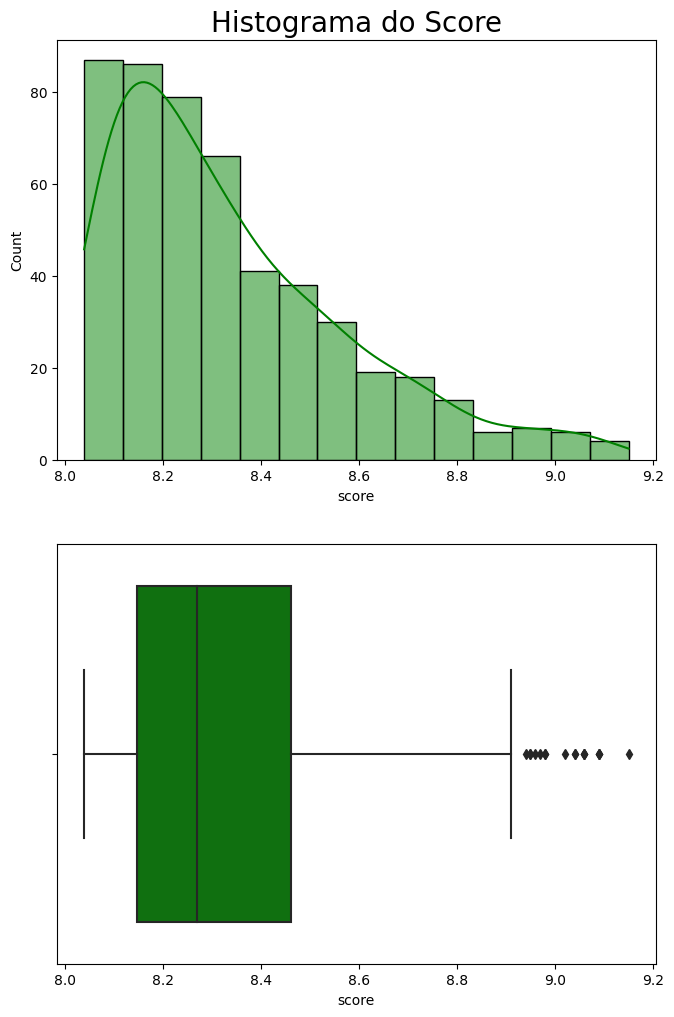

In [167]:
# Figura
plt.figure(figsize = (17,12))

# Subplots com histogramas
# 221 = 2 linhas, 2 colunas, grafico 1; e assim sucessivamente
plt.subplot(221)
# Definindo paleta de cor
sns.color_palette("hls", 8)
# Kde = linha de densidade
sns.histplot(df['score'], kde = True, color = "green")
plt.title('Histograma do Score', fontsize = 20)

# Subplots com boxplots
plt.subplot(223)
sns.boxplot(x=df['score'], color = "green")


plt.show()

In [102]:
df.score.describe()

count    500.000000
mean       8.335520
std        0.241739
min        8.040000
25%        8.147500
50%        8.270000
75%        8.462500
max        9.150000
Name: score, dtype: float64

In [111]:
df.score.mode()

0    8.09
Name: score, dtype: float64

### 2- Qual o anime com maior número de votos?

In [114]:
df.head()

ranking                                name  \
0        1    Fullmetal Alchemist: Brotherhood   
1        2                            Gintama°   
2        3  Shingeki no Kyojin Season 3 Part 2   
3        4                         Steins;Gate   
4        5            Fruits Basket: The Final   

                                           producers  votersCount  score  \
0  Aniplex;SquareEnix;MainichiBroadcastingSystem;...      1650275   9.15   
1                             TVTokyo;Aniplex;Dentsu       173906   9.09   
2  ProductionI.G;Dentsu;MainichiBroadcastingSyste...      1127900   9.09   
3  FrontierWorks;MediaFactory;Movic;AT-X;Kadokawa...      1128557   9.09   
4  TVTokyo;TVOsaka;NihonAdSystems;Hakusensha;Avex...       124091   9.06   

   popularity  members  favorite  episodes animeType premiredDate  \
0           3  2713695    191501      64.0        TV  Spring 2009   
1         337   493336     13063      51.0        TV  Spring 2015   
2          33  1635976     46238      10.0        TV  Spring 2019   
3          12  2117018    162324      24.0        TV  Spring 2011   
4         619   288314     13330      13.0        TV  Spring 2021   

    animeSource                                          genres  \
0         Manga           Action;Adventure;Comedy;Drama;Fantasy   
1         Manga                           Action;Comedy;Sci-;Fi   
2         Manga                    Action;Drama;Fantasy;Mystery   
3  Visual novel                          Drama;Sci-;Fi;Suspense   
4         Manga  Comedy;Drama;Romance;Sliceof;Life;Supernatural   

                 studios                     licenses       rating  \
0                  Bones  Funimation;AniplexofAmerica        R-17+   
1  Bandai Namco Pictures       Funimation;Crunchyroll  PG-13-Teens   
2             Wit Studio                   Funimation        R-17+   
3              White Fox                   Funimation  PG-13-Teens   
4      TMS Entertainment                   Funimation  PG-13-Teens   

                                            Japanese  \
0  Kugimiya,Rie;Park,Romi;Utsumi,Kenji;Utsumi,Ken...   
1  Kugimiya,Rie;Ishii,Kouji;Sugita,Tomokazu;Tomat...   
2  Ishikawa,Yui;Inoue,Marina;Kamiya,Hiroshi;Kaji,...   
3  Seki,Tomokazu;Imai,Asami;Miyano,Mamoru;Hanazaw...   
4  Iwami,Manaka;Uchida,Yuuma;Shimazaki,Nobunaga;S...   

                                             Italian  \
0  Ponticelli,Benedetta;Novara,Renato;Scianca,Pat...   
1                                                NaN   
2  Perino,Elena;Bolognesi,Gaia;Raffaeli,Daniele;C...   
3  Vivio,Paolo;Paolelli,Rachele;Chevalier,Davide;...   
4                                                NaN   

                                      Portuguese(BR)  \
0  Andreatto,Rodrigo;Campos,Marcelo;Zink,Mariana;...   
1                                                NaN   
2  Stefane,Mayara;Volpato,Pedro;Sangregório,Bruno...   
3  Casemiro,Bruno;Cunha,Maitê;Rinaldi,André;Lua,B...   
4  Ruis,Carolina;Campos,Fábio;Volpato,Pedro;Caval...   

                                              German  \
0  Gerick,Wanja;Turba,David;Häcke,Maximiliane;Mai...   
1                                                NaN   
2                                                NaN   
3  Wirthgen,Jesco;Bäcker,Manuela;Gavrilis,Marios;...   
4                                                NaN   

                                           Hungarian  \
0  Baráth,István;Szabó,Máté;Faragó,András;Varga,R...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                             English  \
0  Whitehead,Maxey;Truncale,Lily;Mignogna,Vic;Hof...   
1  Loewen,Jocelyne;Daingerfield,Michael;Pitre,Sab...   
2  Nishimura,Trina;Grelle,Josh;Mercer,Matthew;Pap...   
3  Rinehart,Tyson;Nishimura,Trina;Tatum,JohnMicha...   
4        Yeung,Suzie;Sabat,Christopher;Le

In [116]:
df.votersCount.max()

2220982

In [118]:
df.loc[df['votersCount'].argmax()]

ranking                                                                       100
name                                                           Shingeki no Kyojin
producers                       ProductionI.G;Dentsu;MainichiBroadcastingSyste...
votersCount                                                               2220982
score                                                                        8.52
                                                      ...                        
Co-Producer                                                                   NaN
CastingDirector                                                               NaN
Re-RecordingMixing                                                            NaN
AssistantProductionCoordinat                                                  NaN
SettingManager                                                                NaN
Name: 99, Length: 90, dtype: object

Text(0, 0.5, 'popularity')

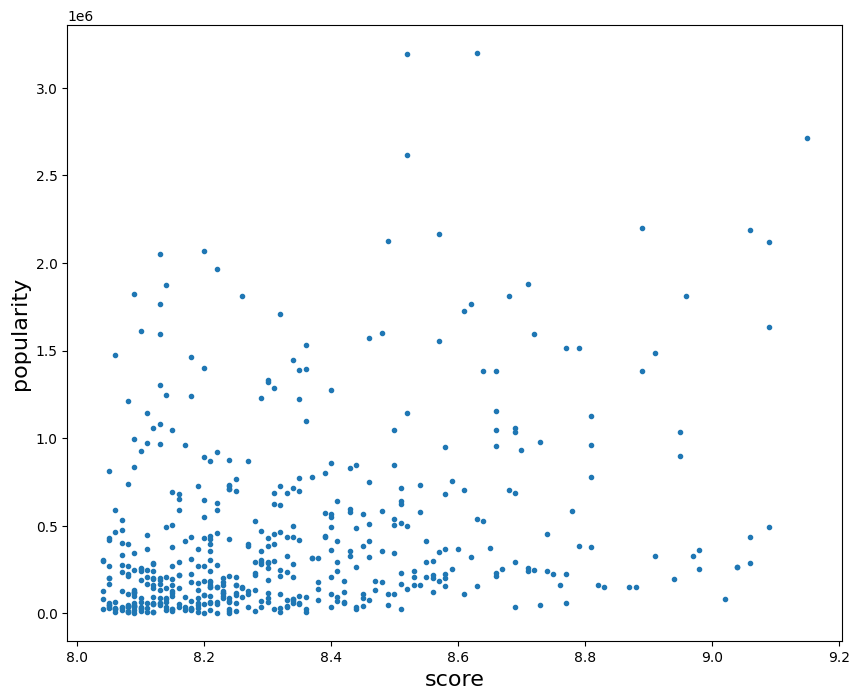

In [125]:
plt.figure(figsize = (10, 8))
plt.scatter((df['score']), df['members'], marker = '.', cmap = 'hot')
plt.xlabel('score', fontsize = 16)
plt.ylabel('popularity', fontsize = 16)
# plt.colorbar().set_label('epsodes', fontsize = 16)

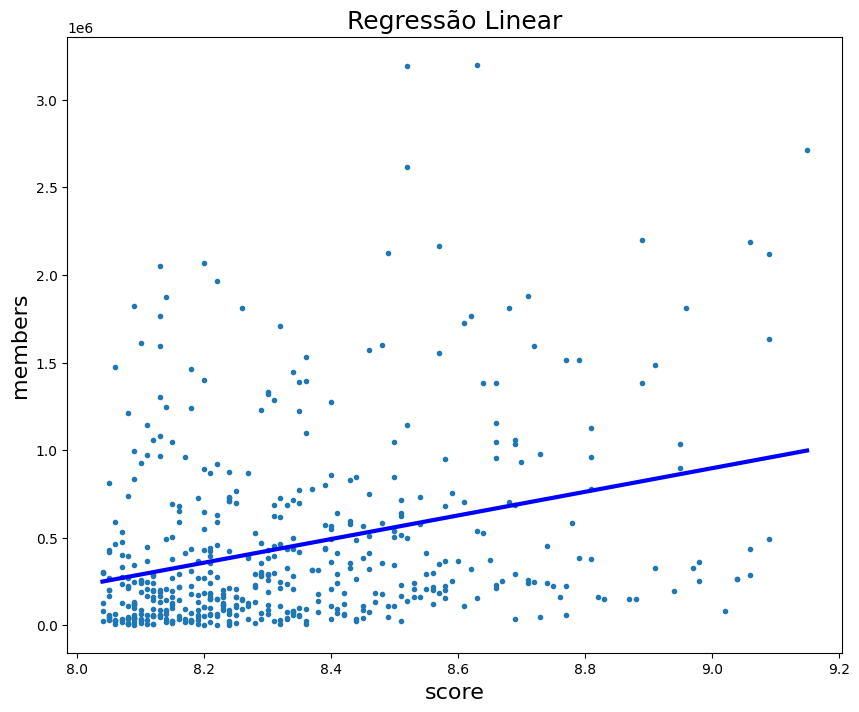

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Extrai as variáveis independentes (X) e dependentes (y)
X = df[['score']]
y = df['members']

# Cria o modelo de regressão linear
model = LinearRegression()

# Treina o modelo
model.fit(X, y)

# Faz previsões para os dados existentes
y_pred = model.predict(X)

# Plota o gráfico de dispersão e a linha de regressão
plt.figure(figsize=(10, 8))
plt.scatter(df['score'], df['members'], marker='.', cmap='hot')
plt.plot(df['score'], y_pred, color='blue', linewidth=3)
plt.xlabel('score', fontsize=16)
plt.ylabel('members', fontsize=16)
plt.title('Regressão Linear', fontsize=18)

# Exibe o gráfico
plt.show()

### 3- Quais os tipos de animes?

In [128]:
df.head()

ranking                                name  \
0        1    Fullmetal Alchemist: Brotherhood   
1        2                            Gintama°   
2        3  Shingeki no Kyojin Season 3 Part 2   
3        4                         Steins;Gate   
4        5            Fruits Basket: The Final   

                                           producers  votersCount  score  \
0  Aniplex;SquareEnix;MainichiBroadcastingSystem;...      1650275   9.15   
1                             TVTokyo;Aniplex;Dentsu       173906   9.09   
2  ProductionI.G;Dentsu;MainichiBroadcastingSyste...      1127900   9.09   
3  FrontierWorks;MediaFactory;Movic;AT-X;Kadokawa...      1128557   9.09   
4  TVTokyo;TVOsaka;NihonAdSystems;Hakusensha;Avex...       124091   9.06   

   popularity  members  favorite  episodes animeType premiredDate  \
0           3  2713695    191501      64.0        TV  Spring 2009   
1         337   493336     13063      51.0        TV  Spring 2015   
2          33  1635976     46238      10.0        TV  Spring 2019   
3          12  2117018    162324      24.0        TV  Spring 2011   
4         619   288314     13330      13.0        TV  Spring 2021   

    animeSource                                          genres  \
0         Manga           Action;Adventure;Comedy;Drama;Fantasy   
1         Manga                           Action;Comedy;Sci-;Fi   
2         Manga                    Action;Drama;Fantasy;Mystery   
3  Visual novel                          Drama;Sci-;Fi;Suspense   
4         Manga  Comedy;Drama;Romance;Sliceof;Life;Supernatural   

                 studios                     licenses       rating  \
0                  Bones  Funimation;AniplexofAmerica        R-17+   
1  Bandai Namco Pictures       Funimation;Crunchyroll  PG-13-Teens   
2             Wit Studio                   Funimation        R-17+   
3              White Fox                   Funimation  PG-13-Teens   
4      TMS Entertainment                   Funimation  PG-13-Teens   

                                            Japanese  \
0  Kugimiya,Rie;Park,Romi;Utsumi,Kenji;Utsumi,Ken...   
1  Kugimiya,Rie;Ishii,Kouji;Sugita,Tomokazu;Tomat...   
2  Ishikawa,Yui;Inoue,Marina;Kamiya,Hiroshi;Kaji,...   
3  Seki,Tomokazu;Imai,Asami;Miyano,Mamoru;Hanazaw...   
4  Iwami,Manaka;Uchida,Yuuma;Shimazaki,Nobunaga;S...   

                                             Italian  \
0  Ponticelli,Benedetta;Novara,Renato;Scianca,Pat...   
1                                                NaN   
2  Perino,Elena;Bolognesi,Gaia;Raffaeli,Daniele;C...   
3  Vivio,Paolo;Paolelli,Rachele;Chevalier,Davide;...   
4                                                NaN   

                                      Portuguese(BR)  \
0  Andreatto,Rodrigo;Campos,Marcelo;Zink,Mariana;...   
1                                                NaN   
2  Stefane,Mayara;Volpato,Pedro;Sangregório,Bruno...   
3  Casemiro,Bruno;Cunha,Maitê;Rinaldi,André;Lua,B...   
4  Ruis,Carolina;Campos,Fábio;Volpato,Pedro;Caval...   

                                              German  \
0  Gerick,Wanja;Turba,David;Häcke,Maximiliane;Mai...   
1                                                NaN   
2                                                NaN   
3  Wirthgen,Jesco;Bäcker,Manuela;Gavrilis,Marios;...   
4                                                NaN   

                                           Hungarian  \
0  Baráth,István;Szabó,Máté;Faragó,András;Varga,R...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                             English  \
0  Whitehead,Maxey;Truncale,Lily;Mignogna,Vic;Hof...   
1  Loewen,Jocelyne;Daingerfield,Michael;Pitre,Sab...   
2  Nishimura,Trina;Grelle,Josh;Mercer,Matthew;Pap...   
3  Rinehart,Tyson;Nishimura,Trina;Tatum,JohnMicha...   
4        Yeung,Suzie;Sabat,Christopher;Le

In [129]:
df['animeType'].value_counts()

TV         295
Movie      112
OVA         37
Special     28
ONA         23
Music        5
Name: animeType, dtype: int64

In [130]:
df.ranking.value_counts()

1      1
330    1
343    1
342    1
341    1
      ..
162    1
161    1
160    1
159    1
500    1
Name: ranking, Length: 500, dtype: int64

In [131]:
df.ranking.describe()

count    500.000000
mean     250.500000
std      144.481833
min        1.000000
25%      125.750000
50%      250.500000
75%      375.250000
max      500.000000
Name: ranking, dtype: float64

In [132]:
df.shape

(500, 90)

In [168]:
# Descobrindo quais os generos possivei para os animes

gener = []
separado = []
for i in df['genres']:
  # print(i)
  if pd.notna(i):
    separado = i.split(';')
  else:
    separado = ['undefined']

  for s in separado:
    if s not in gener:
      gener.append(s)


In [169]:
print(gener)

['Action', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Sci-', 'Fi', 'Mystery', 'Suspense', 'Romance', 'Sliceof', 'Life', 'Supernatural', 'undefined', 'Sports', 'Horror', 'Ecchi', 'Avant', 'Garde', 'Boys', 'Love', 'Gourmet']


In [170]:
gen = {'Action': 0,
       'Sci-': 0,
       'Fi': 0,
       'Mystery': 0,
       'Suspense': 0,
       'Romance': 0,
       'Sliceof': 0,
       'Life': 0,
       'Supernatural': 0,
       'Sports': 0,
       'Horror':0,
       'Ecchi':0,
       'Avant':0,
       'Garde':0,
       'Boys':0,
       'Love':0,
       'Gourmet':0,
       'Adventure': 0,
       'Comedy': 0,
       'Comedy': 0,
       'Fantasy': 0}

In [171]:
# Descobrindo quais os generos possivei para os animes

gener = []
separado = []
for i in df['genres']:
  # print(i)
  if pd.notna(i):
    separado = i.split(';')
  else:
    separado = ['undefined']

  for chave, valor in gen.items():
    for s in separado:
      if s == chave:
        # print(chave)
        soma = valor
        valor += 1
        gen[s] = valor




In [172]:
gen

{'Action': 189,
 'Sci-': 98,
 'Fi': 98,
 'Mystery': 90,
 'Suspense': 26,
 'Romance': 92,
 'Sliceof': 99,
 'Life': 99,
 'Supernatural': 125,
 'Sports': 46,
 'Horror': 12,
 'Ecchi': 10,
 'Avant': 5,
 'Garde': 5,
 'Boys': 4,
 'Love': 4,
 'Gourmet': 3,
 'Adventure': 115,
 'Comedy': 208,
 'Fantasy': 111}

In [173]:
gens = pd.DataFrame(list(gen.items()), columns=['genre', 'total'])

In [174]:
gens

genre  total
0         Action    189
1           Sci-     98
2             Fi     98
3        Mystery     90
4       Suspense     26
5        Romance     92
6        Sliceof     99
7           Life     99
8   Supernatural    125
9         Sports     46
10        Horror     12
11         Ecchi     10
12         Avant      5
13         Garde      5
14          Boys      4
15          Love      4
16       Gourmet      3
17     Adventure    115
18        Comedy    208
19       Fantasy    111

In [182]:
# Arrumando a coluna Sci- e Fi (que estão separadas, porem são a mesma informação)

ind = gens[gens['genre'] == 'Fi'].index[0]
gens['genre'][ind] = 'Sci-Fi'

ind = gens[gens['genre'] == 'Sci-'].index[0]
gens = gens.drop(index=ind)

In [188]:
gens

genre  total
0         Action    189
2         Sci-Fi     98
3        Mystery     90
4       Suspense     26
5        Romance     92
6        Sliceof     99
7           Life     99
8   Supernatural    125
9         Sports     46
10        Horror     12
11         Ecchi     10
12         Avant      5
13         Garde      5
14          Boys      4
15          Love      4
16       Gourmet      3
17     Adventure    115
18        Comedy    208
19       Fantasy    111

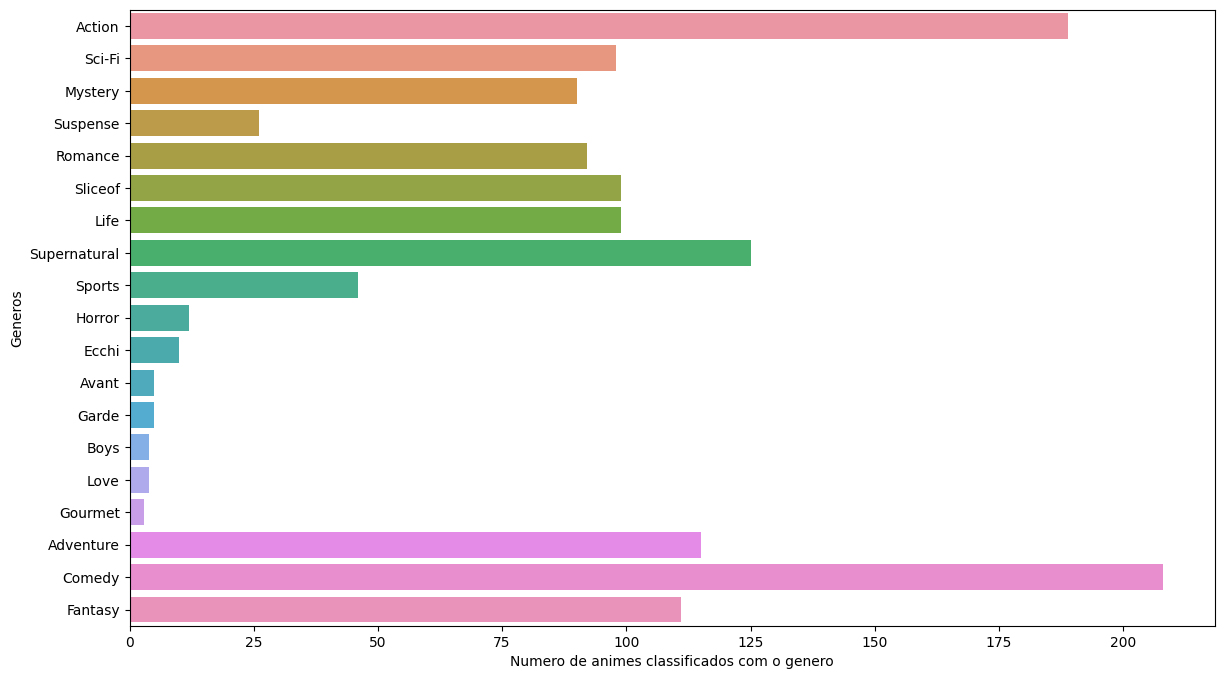

In [189]:
plt.figure(figsize = (14, 8))
sns.barplot(y = 'genre', x = 'total', data = gens)
plt.xlabel('Numero de animes classificados com o genero')
plt.ylabel('Generos')
plt.show()

In [191]:
gens = gens.sort_values(by='total', ascending=False)

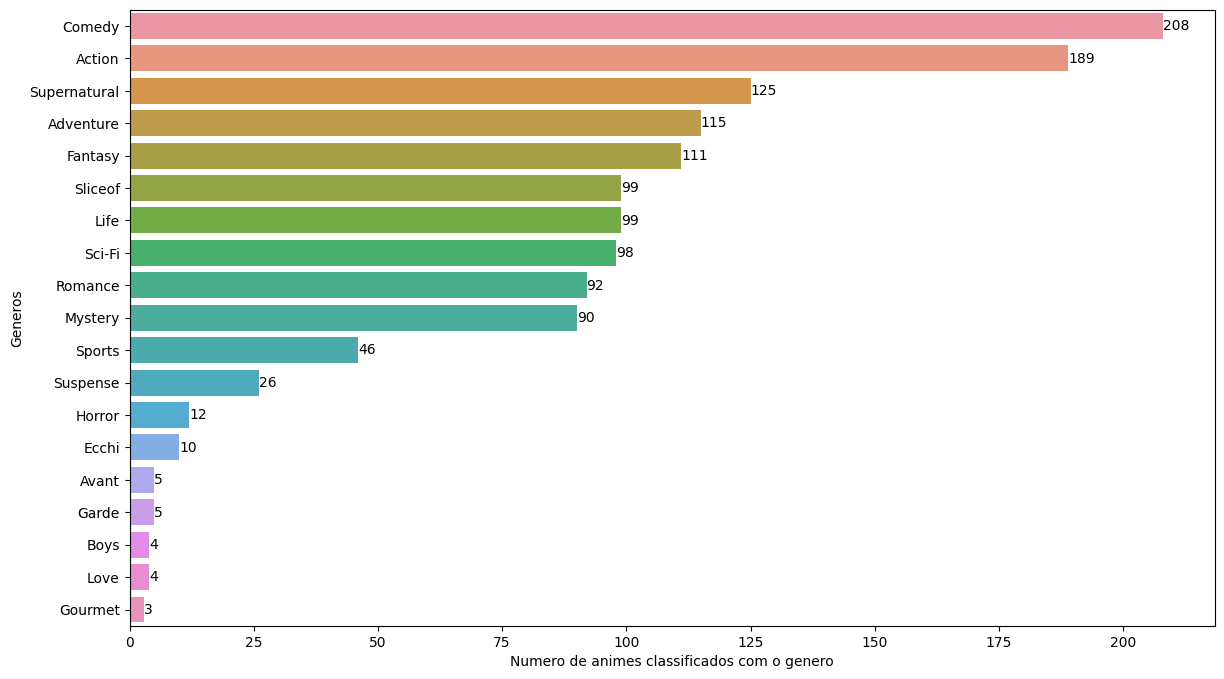

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

# Criando o gráfico de barras
ax = sns.barplot(y='genre', x='total', data=gens)

# Adicionando anotações em cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f}', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=10, color='black')

plt.xlabel('Numero de animes classificados com o genero')
plt.ylabel('Generos')
plt.show()

### 4- Qual a média de score por tipo de anime?

In [194]:
df.groupby(['animeType'])['score'].mean()

animeType
Movie      8.335268
Music      8.296000
ONA        8.324348
OVA        8.223514
Special    8.225000
TV         8.361695
Name: score, dtype: float64

### 5- Quais são as fontes dos animes?

In [198]:
df['animeSource'].value_counts()

Manga           282
Original         67
Light novel      56
Novel            47
Visual novel     15
Web manga        12
Other             7
Game              4
4-koma manga      4
Music             3
Unknown           2
Book              1
Name: animeSource, dtype: int64

In [199]:
contagem_animes = df['animeSource'].value_counts()

# Criando um novo DataFrame chamado 'animesource'
animesource = pd.DataFrame({'fonte': contagem_animes.index, 'total': contagem_animes.values})

animesource = animesource.sort_values(by='total', ascending=False)

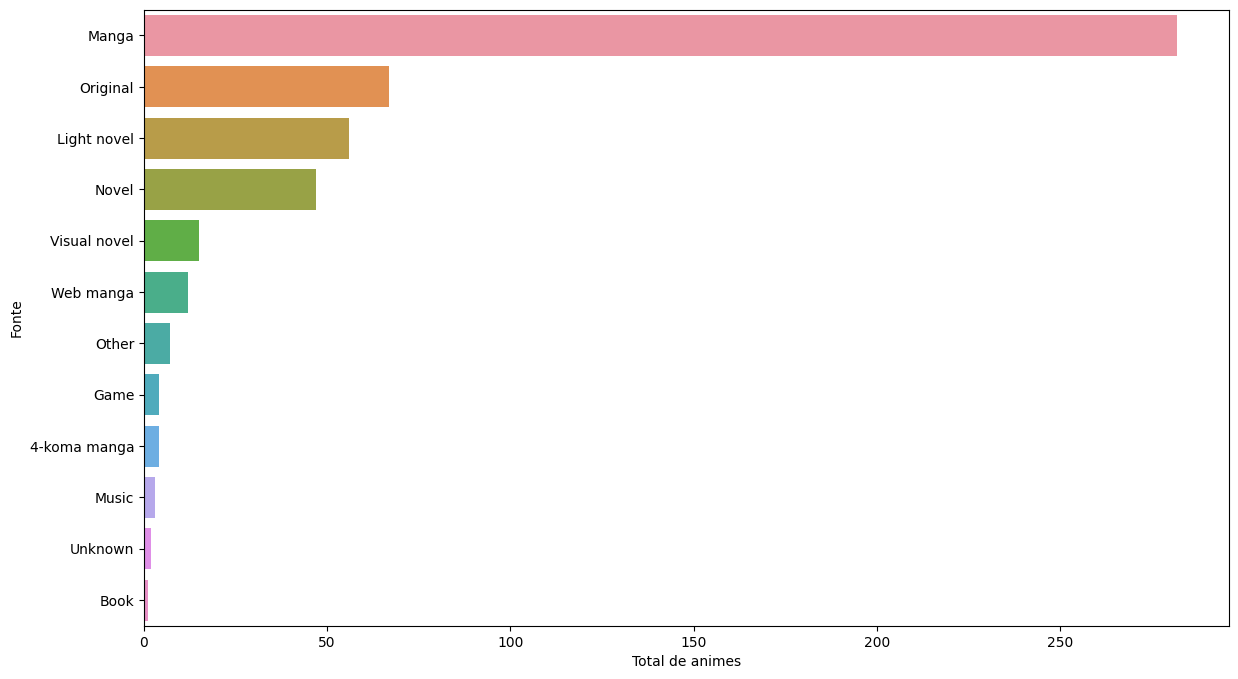

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

# Criando o gráfico de barras
ax = sns.barplot(y='fonte', x='total', data=animesource)

# Adicionando anotações em cada barra

plt.xlabel('Total de animes')
plt.ylabel('Fonte')
plt.show()

### 6- Quantos animes estão disponíveis em português?

In [201]:
df['Portuguese(BR)'].value_counts().sum()

132

### 7- Quantos animes têm co-produtores (Co-Producer)?

In [202]:
df['Co-Producer'].value_counts().sum()

6

### 8- Há animes sem produtores?

In [203]:
df.head()

ranking                                name  \
0        1    Fullmetal Alchemist: Brotherhood   
1        2                            Gintama°   
2        3  Shingeki no Kyojin Season 3 Part 2   
3        4                         Steins;Gate   
4        5            Fruits Basket: The Final   

                                           producers  votersCount  score  \
0  Aniplex;SquareEnix;MainichiBroadcastingSystem;...      1650275   9.15   
1                             TVTokyo;Aniplex;Dentsu       173906   9.09   
2  ProductionI.G;Dentsu;MainichiBroadcastingSyste...      1127900   9.09   
3  FrontierWorks;MediaFactory;Movic;AT-X;Kadokawa...      1128557   9.09   
4  TVTokyo;TVOsaka;NihonAdSystems;Hakusensha;Avex...       124091   9.06   

   popularity  members  favorite  episodes animeType premiredDate  \
0           3  2713695    191501      64.0        TV  Spring 2009   
1         337   493336     13063      51.0        TV  Spring 2015   
2          33  1635976     46238      10.0        TV  Spring 2019   
3          12  2117018    162324      24.0        TV  Spring 2011   
4         619   288314     13330      13.0        TV  Spring 2021   

    animeSource                                          genres  \
0         Manga           Action;Adventure;Comedy;Drama;Fantasy   
1         Manga                           Action;Comedy;Sci-;Fi   
2         Manga                    Action;Drama;Fantasy;Mystery   
3  Visual novel                          Drama;Sci-;Fi;Suspense   
4         Manga  Comedy;Drama;Romance;Sliceof;Life;Supernatural   

                 studios                     licenses       rating  \
0                  Bones  Funimation;AniplexofAmerica        R-17+   
1  Bandai Namco Pictures       Funimation;Crunchyroll  PG-13-Teens   
2             Wit Studio                   Funimation        R-17+   
3              White Fox                   Funimation  PG-13-Teens   
4      TMS Entertainment                   Funimation  PG-13-Teens   

                                            Japanese  \
0  Kugimiya,Rie;Park,Romi;Utsumi,Kenji;Utsumi,Ken...   
1  Kugimiya,Rie;Ishii,Kouji;Sugita,Tomokazu;Tomat...   
2  Ishikawa,Yui;Inoue,Marina;Kamiya,Hiroshi;Kaji,...   
3  Seki,Tomokazu;Imai,Asami;Miyano,Mamoru;Hanazaw...   
4  Iwami,Manaka;Uchida,Yuuma;Shimazaki,Nobunaga;S...   

                                             Italian  \
0  Ponticelli,Benedetta;Novara,Renato;Scianca,Pat...   
1                                                NaN   
2  Perino,Elena;Bolognesi,Gaia;Raffaeli,Daniele;C...   
3  Vivio,Paolo;Paolelli,Rachele;Chevalier,Davide;...   
4                                                NaN   

                                      Portuguese(BR)  \
0  Andreatto,Rodrigo;Campos,Marcelo;Zink,Mariana;...   
1                                                NaN   
2  Stefane,Mayara;Volpato,Pedro;Sangregório,Bruno...   
3  Casemiro,Bruno;Cunha,Maitê;Rinaldi,André;Lua,B...   
4  Ruis,Carolina;Campos,Fábio;Volpato,Pedro;Caval...   

                                              German  \
0  Gerick,Wanja;Turba,David;Häcke,Maximiliane;Mai...   
1                                                NaN   
2                                                NaN   
3  Wirthgen,Jesco;Bäcker,Manuela;Gavrilis,Marios;...   
4                                                NaN   

                                           Hungarian  \
0  Baráth,István;Szabó,Máté;Faragó,András;Varga,R...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                             English  \
0  Whitehead,Maxey;Truncale,Lily;Mignogna,Vic;Hof...   
1  Loewen,Jocelyne;Daingerfield,Michael;Pitre,Sab...   
2  Nishimura,Trina;Grelle,Josh;Mercer,Matthew;Pap...   
3  Rinehart,Tyson;Nishimura,Trina;Tatum,JohnMicha...   
4        Yeung,Suzie;Sabat,Christopher;Le

In [204]:
df["producers"]

0      Aniplex;SquareEnix;MainichiBroadcastingSystem;...
1                                 TVTokyo;Aniplex;Dentsu
2      ProductionI.G;Dentsu;MainichiBroadcastingSyste...
3      FrontierWorks;MediaFactory;Movic;AT-X;Kadokawa...
4      TVTokyo;TVOsaka;NihonAdSystems;Hakusensha;Avex...
                             ...                        
495                                                  NHK
496                                              TVAsahi
497                                       NHK;SogoVision
498    TVTokyo;GeneonUniversalEntertainment;Shogakuka...
499                                    Nonefound;addsome
Name: producers, Length: 500, dtype: object

In [205]:
df[df["producers"].str.contains("Nonefound")]

ranking                                               name  \
29        30    Mushoku Tensei: Isekai Ittara Honki Dasu Part 2   
61        62                      Kimetsu no Yaiba: Yuukaku-hen   
114      115                                     Hotaru no Haka   
117      118                            Gintama: The Semi-Final   
122      123  Kono Subarashii Sekai ni Shukufuku wo! Movie: ...   
..       ...                                                ...   
478      479                                 Kyou kara Ore wa!!   
479      480                                     Pui Pui Molcar   
484      485            Saint Seiya: Meiou Hades Juuni Kyuu-hen   
489      490  Detective Conan Movie 10: Requiem of the Detec...   
499      500  Kono Subarashii Sekai ni Shukufuku wo! 2: Kono...   

             producers  votersCount  score  popularity  members  favorite  \
29   Nonefound;addsome        76025   8.79         438   386457      7617   
61   Nonefound;addsome        31470   8.65         456   373785      6210   
114  Nonefound;addsome       319828   8.50         303   537306      6103   
117  Nonefound;addsome        19715   8.49        2652    46214       203   
122  Nonefound;addsome       358980   8.48         261   583145      4032   
..                 ...          ...    ...         ...      ...       ...   
478  Nonefound;addsome         8471   8.06        3483    27403       320   
479  Nonefound;addsome         5438   8.06        5422     9758       179   
484  Nonefound;addsome        31030   8.05        2515    50047       328   
489  Nonefound;addsome        27897   8.05        2586    48030        38   
499  Nonefound;addsome       181125   8.04         583   300041       683   

     episodes animeType premiredDate  animeSource  \
29       12.0        TV    Fall 2021  Light novel   
61        NaN        TV  Winter 2022        Manga   
114       1.0     Movie          NaN        Novel   
117       2.0   Special          NaN        Manga   
122       1.0     Movie          NaN  Light novel   
..        ...       ...          ...          ...   
478      10.0       OVA          NaN        Manga   
479      12.0        TV  Winter 2021        Other   
484      13.0       OVA          NaN        Manga   
489       1.0     Movie          NaN        Manga   
499       1.0       OVA          NaN  Light novel   

                                    genres                studios  \
29                     Drama;Fantasy;Ecchi            Studio Bind   
61                     Action;Supernatural               ufotable   
114                                    NaN          Studio Ghibli   
117                          Action;Comedy  Bandai Namco Pictures   
122  Adventure;Comedy;Fantasy;Supernatural              J.C.Staff   
..                                     ...                    ...   
478                                    NaN         Studio Pierrot   
479                                    NaN      Shin-Ei Animation   
484                      Adventure;Sci-;Fi         Toei Animation   
489               Adventure;Comedy;Mystery      TMS Entertainment   
499  Adventure;Comedy;Fantasy;Supernatural            Studio Deen   

                                      licenses       rating  \
29                                  Funimation        R-17+   
61                                         NaN        R-17+   
114  ADVFilms;CentralParkMedia;SentaiFilmworks  PG-13-Teens   
117                                        NaN  PG-13-Teens   
122                                        NaN  PG-13-Teens   
..                                         ...          ...   
478                                        NaN        R-17+   
479                          MuseCommunication        G-All   
484                                        NaN  PG-13-Teens   
489                                        NaN  PG-13-Teens   
499                              DiscotekMedia  PG-13-Teens   

                                              Japane

In [206]:
# Vamos substituir "Nonefound" por nan para a próxima análise
df[df["producers"].str.contains("Nonefound")] = np.nan

### 9- Quantos vezes cada produtor participou da produção de um anime?

In [207]:
unique_producers = []

In [208]:
# Extrai os producers únicos
for data in df["producers"]:
    if type(data) != float:
        new_data = data.split(";")
        for producer in new_data:
            if producer not in unique_producers:
                unique_producers.append(producer)

In [209]:
unique_producers

['Aniplex',
 'SquareEnix',
 'MainichiBroadcastingSystem',
 'StudioMoriken',
 'TVTokyo',
 'Dentsu',
 'ProductionI.G',
 'PonyCanyon',
 'Kodansha',
 'TechnoSound',
 'PonyCanyonEnterprise',
 'FrontierWorks',
 'MediaFactory',
 'Movic',
 'AT-X',
 'KadokawaPicturesJapan',
 'Nitroplus',
 'TVOsaka',
 'NihonAdSystems',
 'Hakusensha',
 'AvexPictures',
 'TMSMusic',
 'TrinitySound',
 'MiracleRobo',
 'StudioJack',
 'Shueisha',
 'VAP',
 'NipponTelevisionNetwork',
 'KittyFilms',
 'TokumaShoten',
 'TokumaJapanCommunications',
 'MiracleBus',
 'WarnerBros.Japan',
 'Shochiku',
 'NHK',
 'AsmikAce',
 '"ToysFactory"',
 'ABCAnimation',
 'Quaras',
 'TBS',
 'Rakuonsha',
 'AnimationDo',
 'AudioHighs',
 'Bandai',
 'BandaiVisual',
 'BandaiNamcoEntertainment',
 'HakuhodoDYMediaPartners',
 'Toho',
 'SoundTeamDonJuan',
 'Amuse',
 'JREastMarketing&Communications',
 'Kadokawa',
 'voqueting',
 'FujiTV',
 'bilibili',
 'BeDream',
 'SonyMusicEntertainment',
 'TOHOanimation',
 'KlockWorx',
 'BSFuji',
 'HakuhodoDYMusic&Pictu

In [210]:
# Cria um dicionário
prod_dic = dict()

In [211]:
# Inicializa o dicionário com zero
for i in unique_producers:
    prod_dic[i] = 0

In [212]:
# Agrega os produtores
for prod in unique_producers:
    for i in range(0, len(df["producers"])):
        if type(df["producers"][i]) != float and (df["producers"][i].__contains__(prod)) == True:
            prod_dic[prod] += 1

In [213]:
prod_dic

{'Aniplex': 100,
 'SquareEnix': 9,
 'MainichiBroadcastingSystem': 48,
 'StudioMoriken': 1,
 'TVTokyo': 53,
 'Dentsu': 70,
 'ProductionI.G': 13,
 'PonyCanyon': 29,
 'Kodansha': 52,
 'TechnoSound': 4,
 'PonyCanyonEnterprise': 7,
 'FrontierWorks': 11,
 'MediaFactory': 12,
 'Movic': 48,
 'AT-X': 18,
 'KadokawaPicturesJapan': 6,
 'Nitroplus': 9,
 'TVOsaka': 3,
 'NihonAdSystems': 16,
 'Hakusensha': 15,
 'AvexPictures': 8,
 'TMSMusic': 5,
 'TrinitySound': 4,
 'MiracleRobo': 3,
 'StudioJack': 2,
 'Shueisha': 68,
 'VAP': 22,
 'NipponTelevisionNetwork': 29,
 'KittyFilms': 4,
 'TokumaShoten': 11,
 'TokumaJapanCommunications': 2,
 'MiracleBus': 1,
 'WarnerBros.Japan': 17,
 'Shochiku': 16,
 'NHK': 24,
 'AsmikAce': 8,
 '"ToysFactory"': 6,
 'ABCAnimation': 6,
 'Quaras': 1,
 'TBS': 7,
 'Rakuonsha': 11,
 'AnimationDo': 7,
 'AudioHighs': 2,
 'Bandai': 44,
 'BandaiVisual': 27,
 'BandaiNamcoEntertainment': 5,
 'HakuhodoDYMediaPartners': 6,
 'Toho': 21,
 'SoundTeamDonJuan': 1,
 'Amuse': 1,
 'JREastMarketin

In [214]:
# Ordena o resultado
{k: v for k, v in sorted(prod_dic.items(), key = lambda item: item[1])}

{'StudioMoriken': 1,
 'MiracleBus': 1,
 'Quaras': 1,
 'SoundTeamDonJuan': 1,
 'Amuse': 1,
 'BeDream': 1,
 'dugout': 1,
 'Sumzap': 1,
 'Annapuru': 1,
 'Takeshobo': 1,
 'SKYPerfectWellThink': 1,
 'ScienceSARU': 1,
 'TAP': 1,
 'Madhouse': 1,
 'HiroshimaTelevision': 1,
 'CA-CygamesAnimeFund': 1,
 'NewGin': 1,
 'Sega': 1,
 'MadBox': 1,
 'Sonilude': 1,
 'RexEntertainment': 1,
 'BarnumStudio': 1,
 'TCEntertainment': 1,
 'NipponTelevisionMusic': 1,
 'FBC': 1,
 'SpaceyMusicEntertainment': 1,
 'HeartCompany': 1,
 'TrilogyFutureStudio': 1,
 'Shout!Factory': 1,
 'YomiuriShimbun': 1,
 'MediaLinkEntertainmentLimited': 1,
 'Bitgrooovepromotion': 1,
 'NAZ': 1,
 'ReddogCultureHouse': 1,
 'Sunrise': 1,
 'StudioRFInc.': 1,
 'ShounenGahousha': 1,
 'ForecastCommunications': 1,
 'EggFirm': 1,
 'GREE': 1,
 'OLM': 1,
 'VoyagerEntertainment': 1,
 'Shinshokan': 1,
 'D.N.DreamPartners': 1,
 'STORY': 1,
 'LawsonEntertainment': 1,
 'Gainax': 1,
 'C-one': 1,
 'Infinite': 1,
 'ADKMarketingSolutions': 1,
 'StudioWomb

In [215]:
prod_dic["Aniplex"]

100

### 10- Considerando o produtor que mais participou da produção de animes, qual a média de score, popularidade e membros?

In [216]:
# Remove os valores NA
df2 = df.dropna(subset = ['producers'])

In [217]:
# Filtra pelo producer e gera um novo dataframe
df3 = df2[df2["producers"].str.contains("Aniplex")]

In [218]:
df3.shape

(100, 90)

In [219]:
df3['score'].mean()

8.4619

In [220]:
df3['popularity'].mean()

672.04

In [221]:
df3['members'].mean()

575046.02